In [1]:
import sys
sys.path.append('../RecSysRep/')

In [2]:
import Basics.Load as ld
import scipy.sparse as sps

URM_all, ICM1, ICM2, ICM3, ICM4 = ld.getCOOs()
ICML = ld.getICMlength('5km')
ICM_weighted = ld.getICMselected('7')
ICM_all = sps.hstack([ICM1, ICM3, ICML])
# URM_train, URM_val = ld.getSplit(URM_train_val, 5678, 0.8)

In [3]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8, seed=1999)
# URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_validation, train_percentage = 0.8)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
# evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions


In [4]:
import os

ofp = "../models_temp/Similarity_Hybrid/"

models_to_combine_best = {
                            'IALS_Hyb' : {"num_factors": 28, "epochs": 10, "confidence_scaling": "linear", "alpha": 0.43657990940994623, "epsilon": 0.35472063248578317, "reg": 0.0001698292271931609, "mw": 0.06122362507952762},
                            'RP3ICMnew': {'alpha': 1.029719677583138, 'beta': 1.0630164752134375, 'topK': 6964, 'normalize_similarity': True},
                            'RP3ICM' : {"topK": 2550, "alpha": 1.3058102610510849, "beta": 0.5150718337969987, "normalize_similarity": True, "implicit": True},
                            'IALS' : {'num_factors': 34, 'epochs': 599, 'confidence_scaling': 'linear', 'alpha': 0.003519435539271083, 'epsilon': 0.09222402080721787, 'reg': 2.4127708108457617e-05},
                            'SLIMgensub': {"l1_ratio" : 0.025887359156206147, "topK": 2140, "alpha": 0.009567288586539689, "workers": 8, "mw": 1},
                            'SLIMBPR' : {"epochs": 440, "lambda_i": 0.007773815998802306, "lambda_j": 0.003342522366982381, "learning_rate": 0.010055161410725193, "topK": 4289, "random_seed": 1234, "sgd_mode": "sgd"},
                            'SLIMweig': {'l1_ratio': 0.0005247075138160404, 'topK': 4983, 'alpha': 0.06067400905430761, 'workers': 8, 'mw': 2.308619939318322},
                            'SLIMER': {'topK': 6000, 'l1_ratio': 0.0005495104968035837, 'alpha': 0.08007142704041009, 'workers': 8},
                            'P3alpha': {'topK': 4834, 'alpha': 1.764994849187595, 'normalize_similarity': True, 'implicit': True},
                            'RP3beta': {"topK": 1049, "alpha": 1.1626473723475605, "beta": 0.6765017195261293, "normalize_similarity": True, "implicit": True},
                            'icm_7': {"shrink": 4000, "topK": 985, "feature_weighting": "TF-IDF", "normalize": True},
                            'icm_3': {'shrink': 2211, 'topK': 188, 'feature_weighting': 'TF-IDF', 'normalize': True},
                            'icm_9': {'shrink': 3568, 'topK': 986, 'feature_weighting': 'TF-IDF', 'normalize': True},
                            'icm_all': {"shrink": 5212, "topK": 923, "feature_weighting": "TF-IDF", "normalize": True},
                            'icm_channel': {"shrink": 2000, "topK": 382, "feature_weighting": "TF-IDF", "normalize": False},
                            'UserKNN' : {'topK': 448, 'similarity': 'cosine', 'shrink': 756, 'normalize': True, 'feature_weighting': 'TF-IDF', 'URM_bias': True},
                         }


In [5]:
def model_init(recommender, name, args):
    path_name = ofp + name + ".zip"
    print(path_name)
    if os.path.exists(path_name):
        print("Model found!")
        recommender.load_model(ofp, name)
    else:
        print("Model does not exists, creating...")
        if not os.path.exists(ofp):
            print("Main folder does not exist, creating...")
            os.makedirs(ofp)
        recommender.fit(**args)
        recommender.save_model(ofp, name)

In [6]:
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommenderICM
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender_Hybrid

In [7]:
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.KNN.ItemKNNSimilarityHybridRecommenderNormal import ItemKNNSimilarityHybridRecommenderNormal
from Recommenders.KNN.ItemKNNScoresHybridMultipleRecommender import ItemKNNScoresHybridMultipleRecommender
from Recommenders.HybridScores.DifferentStructure import TwoDifferentModelRecommender

In [8]:
recommender1 = MultiThreadSLIM_SLIMElasticNetRecommender(URM_train)
recommender2 = UserKNNCFRecommender(URM_train)

model_init(recommender1, 'SLIM_pure', models_to_combine_best['SLIMER'])
model_init(recommender2, 'UserKNN', models_to_combine_best['UserKNN'])

../models_temp/Similarity_Hybrid/SLIM_pure.zip
Model found!
SLIMElasticNetRecommender: Loading model from file '../models_temp/Similarity_Hybrid/SLIM_pure'
SLIMElasticNetRecommender: Loading complete
../models_temp/Similarity_Hybrid/UserKNN.zip
Model found!
UserKNNCFRecommender: Loading model from file '../models_temp/Similarity_Hybrid/UserKNN'
UserKNNCFRecommender: Loading complete


In [9]:
def rank_models(evaluator, recommenders):
    for r in recommenders:
        r_d, _ = evaluator.evaluateRecommender(r)
        print(r.RECOMMENDER_NAME, r_d.loc[10]['MAP'])

In [10]:
rank_models(evaluator_validation, [recommender1, recommender2])

EvaluatorHoldout: Processed 13646 (100.0%) in 15.61 sec. Users per second: 874
SLIMElasticNetRecommender 0.24746682846767187
EvaluatorHoldout: Processed 13646 (100.0%) in 12.33 sec. Users per second: 1106
UserKNNCFRecommender 0.2311445967072166


In [11]:
import matplotlib.pyplot as plt
import numpy as np

In [12]:
import numpy as np

def test_percentage(recommender_a, recommender_b, evaluator, high1, low1, step):
    recommender = TwoDifferentModelRecommender(URM_train, recommender_a, recommender_b)
    results = []
    alp_space = np.linspace(high1, low1, step, True)
    for alp in alp_space:
        recommender.fit(None, alp)
        r_d, _ = evaluator.evaluateRecommender(recommender)
        print(alp, ":", r_d.loc[10]['MAP'])
        results.append(r_d.loc[10]['MAP'])
    
    return alp_space, results

EvaluatorHoldout: Processed 13646 (100.0%) in 24.79 sec. Users per second: 550
0.99392 : 0.248314373186863
EvaluatorHoldout: Processed 13646 (100.0%) in 25.56 sec. Users per second: 534
0.9939205263157895 : 0.2483070450320924
EvaluatorHoldout: Processed 13646 (100.0%) in 26.18 sec. Users per second: 521
0.9939210526315789 : 0.2483070450320924
EvaluatorHoldout: Processed 13646 (100.0%) in 25.11 sec. Users per second: 544
0.9939215789473684 : 0.24830614936873152
EvaluatorHoldout: Processed 13646 (100.0%) in 25.23 sec. Users per second: 541
0.9939221052631579 : 0.24830370665047463
EvaluatorHoldout: Processed 13646 (100.0%) in 24.82 sec. Users per second: 550
0.9939226315789473 : 0.24830370665047463
EvaluatorHoldout: Processed 13646 (100.0%) in 24.51 sec. Users per second: 557
0.9939231578947368 : 0.2483045354298832
EvaluatorHoldout: Processed 13646 (100.0%) in 24.58 sec. Users per second: 555
0.9939236842105263 : 0.24830482041367988
EvaluatorHoldout: Processed 13646 (100.0%) in 25.18 sec.

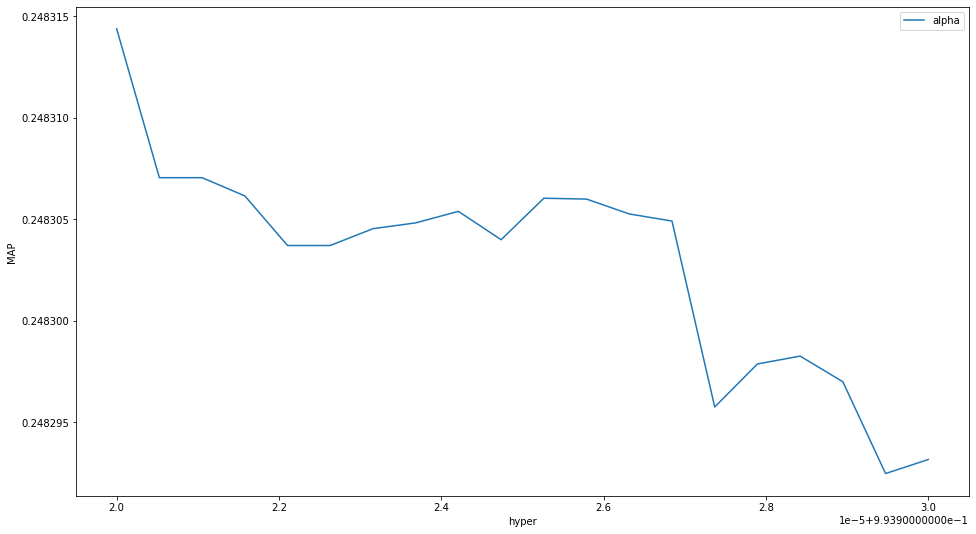

In [19]:
alp_space, results = test_percentage(recommender1, recommender2, evaluator_validation, 0.99392, 0.99393, 20)
_ = plt.figure(figsize=(16, 9))
plt.plot(alp_space, results, label='alpha')
plt.ylabel('MAP')
plt.xlabel('hyper')
plt.legend()
plt.show()

In [23]:
recommender2 = IALSRecommender(URM_train)

model_init(recommender2, 'IALSn', models_to_combine_best['IALS'])

../models_temp/Similarity_Hybrid/IALSn.zip
Model does not exists, creating...
IALSRecommender: Epoch 1 of 599. Elapsed time 5.28 sec
IALSRecommender: Epoch 2 of 599. Elapsed time 10.54 sec
IALSRecommender: Epoch 3 of 599. Elapsed time 15.79 sec
IALSRecommender: Epoch 4 of 599. Elapsed time 21.44 sec
IALSRecommender: Epoch 5 of 599. Elapsed time 27.78 sec
IALSRecommender: Epoch 6 of 599. Elapsed time 33.51 sec
IALSRecommender: Epoch 7 of 599. Elapsed time 39.18 sec
IALSRecommender: Epoch 8 of 599. Elapsed time 44.96 sec
IALSRecommender: Epoch 9 of 599. Elapsed time 50.69 sec
IALSRecommender: Epoch 10 of 599. Elapsed time 56.22 sec
IALSRecommender: Epoch 11 of 599. Elapsed time 1.03 min
IALSRecommender: Epoch 12 of 599. Elapsed time 1.13 min
IALSRecommender: Epoch 13 of 599. Elapsed time 1.22 min
IALSRecommender: Epoch 14 of 599. Elapsed time 1.31 min
IALSRecommender: Epoch 15 of 599. Elapsed time 1.41 min
IALSRecommender: Epoch 16 of 599. Elapsed time 1.50 min
IALSRecommender: Epoch 17 

IALSRecommender: Epoch 144 of 599. Elapsed time 31.36 min
IALSRecommender: Epoch 145 of 599. Elapsed time 31.62 min
IALSRecommender: Epoch 146 of 599. Elapsed time 31.72 min
IALSRecommender: Epoch 147 of 599. Elapsed time 31.98 min
IALSRecommender: Epoch 148 of 599. Elapsed time 32.08 min
IALSRecommender: Epoch 149 of 599. Elapsed time 32.34 min
IALSRecommender: Epoch 150 of 599. Elapsed time 32.46 min
IALSRecommender: Epoch 151 of 599. Elapsed time 32.72 min
IALSRecommender: Epoch 152 of 599. Elapsed time 32.82 min
IALSRecommender: Epoch 153 of 599. Elapsed time 33.08 min
IALSRecommender: Epoch 154 of 599. Elapsed time 33.19 min
IALSRecommender: Epoch 155 of 599. Elapsed time 33.46 min
IALSRecommender: Epoch 156 of 599. Elapsed time 33.58 min
IALSRecommender: Epoch 157 of 599. Elapsed time 33.82 min
IALSRecommender: Epoch 158 of 599. Elapsed time 33.94 min
IALSRecommender: Epoch 159 of 599. Elapsed time 34.19 min
IALSRecommender: Epoch 160 of 599. Elapsed time 34.32 min
IALSRecommende

IALSRecommender: Epoch 286 of 599. Elapsed time 56.19 min
IALSRecommender: Epoch 287 of 599. Elapsed time 56.36 min
IALSRecommender: Epoch 288 of 599. Elapsed time 56.53 min
IALSRecommender: Epoch 289 of 599. Elapsed time 56.70 min
IALSRecommender: Epoch 290 of 599. Elapsed time 56.87 min
IALSRecommender: Epoch 291 of 599. Elapsed time 57.04 min
IALSRecommender: Epoch 292 of 599. Elapsed time 57.21 min
IALSRecommender: Epoch 293 of 599. Elapsed time 57.37 min
IALSRecommender: Epoch 294 of 599. Elapsed time 57.54 min
IALSRecommender: Epoch 295 of 599. Elapsed time 57.71 min
IALSRecommender: Epoch 296 of 599. Elapsed time 57.89 min
IALSRecommender: Epoch 297 of 599. Elapsed time 58.05 min
IALSRecommender: Epoch 298 of 599. Elapsed time 58.23 min
IALSRecommender: Epoch 299 of 599. Elapsed time 58.39 min
IALSRecommender: Epoch 300 of 599. Elapsed time 58.56 min
IALSRecommender: Epoch 301 of 599. Elapsed time 58.72 min
IALSRecommender: Epoch 302 of 599. Elapsed time 58.81 min
IALSRecommende

IALSRecommender: Epoch 428 of 599. Elapsed time 1.35 hour
IALSRecommender: Epoch 429 of 599. Elapsed time 1.35 hour
IALSRecommender: Epoch 430 of 599. Elapsed time 1.35 hour
IALSRecommender: Epoch 431 of 599. Elapsed time 1.36 hour
IALSRecommender: Epoch 432 of 599. Elapsed time 1.36 hour
IALSRecommender: Epoch 433 of 599. Elapsed time 1.36 hour
IALSRecommender: Epoch 434 of 599. Elapsed time 1.36 hour
IALSRecommender: Epoch 435 of 599. Elapsed time 1.37 hour
IALSRecommender: Epoch 436 of 599. Elapsed time 1.37 hour
IALSRecommender: Epoch 437 of 599. Elapsed time 1.37 hour
IALSRecommender: Epoch 438 of 599. Elapsed time 1.38 hour
IALSRecommender: Epoch 439 of 599. Elapsed time 1.38 hour
IALSRecommender: Epoch 440 of 599. Elapsed time 1.38 hour
IALSRecommender: Epoch 441 of 599. Elapsed time 1.38 hour
IALSRecommender: Epoch 442 of 599. Elapsed time 1.39 hour
IALSRecommender: Epoch 443 of 599. Elapsed time 1.39 hour
IALSRecommender: Epoch 444 of 599. Elapsed time 1.39 hour
IALSRecommende

IALSRecommender: Epoch 570 of 599. Elapsed time 1.73 hour
IALSRecommender: Epoch 571 of 599. Elapsed time 1.73 hour
IALSRecommender: Epoch 572 of 599. Elapsed time 1.73 hour
IALSRecommender: Epoch 573 of 599. Elapsed time 1.73 hour
IALSRecommender: Epoch 574 of 599. Elapsed time 1.73 hour
IALSRecommender: Epoch 575 of 599. Elapsed time 1.73 hour
IALSRecommender: Epoch 576 of 599. Elapsed time 1.73 hour
IALSRecommender: Epoch 577 of 599. Elapsed time 1.74 hour
IALSRecommender: Epoch 578 of 599. Elapsed time 1.74 hour
IALSRecommender: Epoch 579 of 599. Elapsed time 1.74 hour
IALSRecommender: Epoch 580 of 599. Elapsed time 1.74 hour
IALSRecommender: Epoch 581 of 599. Elapsed time 1.74 hour
IALSRecommender: Epoch 582 of 599. Elapsed time 1.74 hour
IALSRecommender: Epoch 583 of 599. Elapsed time 1.74 hour
IALSRecommender: Epoch 584 of 599. Elapsed time 1.74 hour
IALSRecommender: Epoch 585 of 599. Elapsed time 1.75 hour
IALSRecommender: Epoch 586 of 599. Elapsed time 1.75 hour
IALSRecommende

In [25]:

models_to_combine_best = {
                            'RP3ICMnew': {'alpha': 1.029719677583138, 'beta': 1.0630164752134375, 'topK': 6964, 'normalize_similarity': True},
                            'RP3ICM' : {"topK": 2550, "alpha": 1.3058102610510849, "beta": 0.5150718337969987, "normalize_similarity": True, "implicit": True},
                            'IALS' : {'num_factors': 34, 'epochs': 599, 'confidence_scaling': 'linear', 'alpha': 0.003519435539271083, 'epsilon': 0.09222402080721787, 'reg': 2.4127708108457617e-05},
                            'SLIMgensub': {"l1_ratio" : 0.025887359156206147, "topK": 2140, "alpha": 0.009567288586539689, "workers": 8, "mw": 1},
                            'SLIMBPR' : {"epochs": 440, "lambda_i": 0.007773815998802306, "lambda_j": 0.003342522366982381, "learning_rate": 0.010055161410725193, "topK": 4289, "random_seed": 1234, "sgd_mode": "sgd"},
                            'SLIMweig': {'l1_ratio': 0.0005247075138160404, 'topK': 4983, 'alpha': 0.06067400905430761, 'workers': 8, 'mw': 2.308619939318322},
                            'SLIMER': {'topK': 6000, 'l1_ratio': 0.0005495104968035837, 'alpha': 0.08007142704041009, 'workers': 8},
                            'P3alpha': {'topK': 4834, 'alpha': 1.764994849187595, 'normalize_similarity': True, 'implicit': True},
                            'RP3beta': {"topK": 1049, "alpha": 1.1626473723475605, "beta": 0.6765017195261293, "normalize_similarity": True, "implicit": True},
                            'icm_7': {"shrink": 4000, "topK": 985, "feature_weighting": "TF-IDF", "normalize": True},
                            'icm_3': {'shrink': 2211, 'topK': 188, 'feature_weighting': 'TF-IDF', 'normalize': True},
                            'icm_9': {'shrink': 3568, 'topK': 986, 'feature_weighting': 'TF-IDF', 'normalize': True},
                            'icm_all': {"shrink": 5212, "topK": 923, "feature_weighting": "TF-IDF", "normalize": True},
                            'icm_channel': {"shrink": 2000, "topK": 382, "feature_weighting": "TF-IDF", "normalize": False},
                            'UserKNN' : {'topK': 448, 'similarity': 'cosine', 'shrink': 756, 'normalize': True, 'feature_weighting': 'TF-IDF', 'URM_bias': True},
                         }

In [26]:
ICM_weighted_7 = ld.getICMselected('7')

recommender1 = MultiThreadSLIM_SLIMElasticNetRecommender(URM_all)
recommender2 = ItemKNNCBFRecommender(URM_all, ICM_weighted_7)
recommender3 = SLIM_BPR_Cython(URM_all)
recommender4 = IALSRecommender(URM_all)

model_init(recommender1, 'SLIM_pure_all', models_to_combine_best['SLIMER'])
model_init(recommender2, 'KNN_all', models_to_combine_best['icm_7'])
model_init(recommender3, 'SLIM_BPR_all', models_to_combine_best['SLIMBPR'])
model_init(recommender4, 'IALS_ALL', models_to_combine_best['IALS'])

ItemKNNCBFRecommender: ICM Detected 22 ( 0.1%) items with no features.
../models_temp/Similarity_Hybrid/SLIM_pure_all.zip
Model found!
SLIMElasticNetRecommender: Loading model from file '../models_temp/Similarity_Hybrid/SLIM_pure_all'
SLIMElasticNetRecommender: Loading complete
../models_temp/Similarity_Hybrid/KNN_all.zip
Model does not exists, creating...
Similarity column 18059 (100.0%), 5254.68 column/sec. Elapsed time 3.44 sec
ItemKNNCBFRecommender: Saving model in file '../models_temp/Similarity_Hybrid/KNN_all'
ItemKNNCBFRecommender: Saving complete
../models_temp/Similarity_Hybrid/SLIM_BPR_all.zip
Model does not exists, creating...
Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Unable to get current RAM status, you may be using a non-Linux operating system. Using dense matrix.
Processed 13650 (100.0%) in 0.70 sec. BPR loss is 1.85E+00. Sample per second: 19558
SLIM_BPR_Recommender: Epoch 1 of 440. Elapsed tim

SLIM_BPR_Recommender: Epoch 51 of 440. Elapsed time 29.88 sec
Processed 13650 (100.0%) in 0.62 sec. BPR loss is 3.01E+01. Sample per second: 22172
SLIM_BPR_Recommender: Epoch 52 of 440. Elapsed time 30.47 sec
Processed 13650 (100.0%) in 1.19 sec. BPR loss is 3.07E+01. Sample per second: 11511
SLIM_BPR_Recommender: Epoch 53 of 440. Elapsed time 31.04 sec
Processed 13650 (100.0%) in 0.78 sec. BPR loss is 3.07E+01. Sample per second: 17594
SLIM_BPR_Recommender: Epoch 54 of 440. Elapsed time 31.63 sec
Processed 13650 (100.0%) in 1.35 sec. BPR loss is 3.05E+01. Sample per second: 10133
SLIM_BPR_Recommender: Epoch 55 of 440. Elapsed time 32.20 sec
Processed 13650 (100.0%) in 0.93 sec. BPR loss is 3.08E+01. Sample per second: 14616
SLIM_BPR_Recommender: Epoch 56 of 440. Elapsed time 32.79 sec
Processed 13650 (100.0%) in 1.52 sec. BPR loss is 3.12E+01. Sample per second: 8966
SLIM_BPR_Recommender: Epoch 57 of 440. Elapsed time 33.38 sec
Processed 13650 (100.0%) in 1.10 sec. BPR loss is 3.19E+0

SLIM_BPR_Recommender: Epoch 107 of 440. Elapsed time 1.04 min
Processed 13650 (100.0%) in 1.52 sec. BPR loss is 3.70E+01. Sample per second: 9009
SLIM_BPR_Recommender: Epoch 108 of 440. Elapsed time 1.06 min
Processed 13650 (100.0%) in 1.17 sec. BPR loss is 3.65E+01. Sample per second: 11686
SLIM_BPR_Recommender: Epoch 109 of 440. Elapsed time 1.07 min
Processed 13650 (100.0%) in 0.79 sec. BPR loss is 3.64E+01. Sample per second: 17215
SLIM_BPR_Recommender: Epoch 110 of 440. Elapsed time 1.08 min
Processed 13650 (100.0%) in 1.36 sec. BPR loss is 3.72E+01. Sample per second: 10046
SLIM_BPR_Recommender: Epoch 111 of 440. Elapsed time 1.09 min
Processed 13650 (100.0%) in 0.92 sec. BPR loss is 3.62E+01. Sample per second: 14796
SLIM_BPR_Recommender: Epoch 112 of 440. Elapsed time 1.10 min
Processed 13650 (100.0%) in 1.49 sec. BPR loss is 3.70E+01. Sample per second: 9144
SLIM_BPR_Recommender: Epoch 113 of 440. Elapsed time 1.11 min
Processed 13650 (100.0%) in 1.09 sec. BPR loss is 3.81E+01

SLIM_BPR_Recommender: Epoch 163 of 440. Elapsed time 1.58 min
Processed 13650 (100.0%) in 1.41 sec. BPR loss is 4.08E+01. Sample per second: 9669
SLIM_BPR_Recommender: Epoch 164 of 440. Elapsed time 1.59 min
Processed 13650 (100.0%) in 1.02 sec. BPR loss is 3.85E+01. Sample per second: 13407
SLIM_BPR_Recommender: Epoch 165 of 440. Elapsed time 1.60 min
Processed 13650 (100.0%) in 0.72 sec. BPR loss is 3.96E+01. Sample per second: 18840
SLIM_BPR_Recommender: Epoch 166 of 440. Elapsed time 1.61 min
Processed 13650 (100.0%) in 1.39 sec. BPR loss is 3.94E+01. Sample per second: 9804
SLIM_BPR_Recommender: Epoch 167 of 440. Elapsed time 1.62 min
Processed 13650 (100.0%) in 1.08 sec. BPR loss is 3.91E+01. Sample per second: 12584
SLIM_BPR_Recommender: Epoch 168 of 440. Elapsed time 1.63 min
Processed 13650 (100.0%) in 0.67 sec. BPR loss is 4.00E+01. Sample per second: 20224
SLIM_BPR_Recommender: Epoch 169 of 440. Elapsed time 1.64 min
Processed 13650 (100.0%) in 1.23 sec. BPR loss is 3.84E+01

SLIM_BPR_Recommender: Epoch 219 of 440. Elapsed time 2.12 min
Processed 13650 (100.0%) in 0.87 sec. BPR loss is 4.04E+01. Sample per second: 15610
SLIM_BPR_Recommender: Epoch 220 of 440. Elapsed time 2.13 min
Processed 13650 (100.0%) in 1.46 sec. BPR loss is 4.11E+01. Sample per second: 9364
SLIM_BPR_Recommender: Epoch 221 of 440. Elapsed time 2.14 min
Processed 13650 (100.0%) in 1.03 sec. BPR loss is 4.05E+01. Sample per second: 13254
SLIM_BPR_Recommender: Epoch 222 of 440. Elapsed time 2.15 min
Processed 13650 (100.0%) in 0.59 sec. BPR loss is 4.01E+01. Sample per second: 23032
SLIM_BPR_Recommender: Epoch 223 of 440. Elapsed time 2.16 min
Processed 13650 (100.0%) in 1.18 sec. BPR loss is 3.96E+01. Sample per second: 11596
SLIM_BPR_Recommender: Epoch 224 of 440. Elapsed time 2.17 min
Processed 13650 (100.0%) in 0.75 sec. BPR loss is 4.10E+01. Sample per second: 18146
SLIM_BPR_Recommender: Epoch 225 of 440. Elapsed time 2.18 min
Processed 13650 (100.0%) in 1.30 sec. BPR loss is 4.09E+0

SLIM_BPR_Recommender: Epoch 275 of 440. Elapsed time 2.66 min
Processed 13650 (100.0%) in 1.41 sec. BPR loss is 4.42E+01. Sample per second: 9692
SLIM_BPR_Recommender: Epoch 276 of 440. Elapsed time 2.67 min
Processed 13650 (100.0%) in 0.93 sec. BPR loss is 4.21E+01. Sample per second: 14632
SLIM_BPR_Recommender: Epoch 277 of 440. Elapsed time 2.68 min
Processed 13650 (100.0%) in 1.46 sec. BPR loss is 4.36E+01. Sample per second: 9368
SLIM_BPR_Recommender: Epoch 278 of 440. Elapsed time 2.69 min
Processed 13650 (100.0%) in 0.98 sec. BPR loss is 4.32E+01. Sample per second: 13946
SLIM_BPR_Recommender: Epoch 279 of 440. Elapsed time 2.70 min
Processed 13650 (100.0%) in 1.50 sec. BPR loss is 4.19E+01. Sample per second: 9097
SLIM_BPR_Recommender: Epoch 280 of 440. Elapsed time 2.71 min
Processed 13650 (100.0%) in 1.02 sec. BPR loss is 4.14E+01. Sample per second: 13326
SLIM_BPR_Recommender: Epoch 281 of 440. Elapsed time 2.71 min
Processed 13650 (100.0%) in 0.55 sec. BPR loss is 4.24E+01.

SLIM_BPR_Recommender: Epoch 331 of 440. Elapsed time 3.15 min
Processed 13650 (100.0%) in 0.80 sec. BPR loss is 4.39E+01. Sample per second: 17081
SLIM_BPR_Recommender: Epoch 332 of 440. Elapsed time 3.16 min
Processed 13650 (100.0%) in 1.32 sec. BPR loss is 4.33E+01. Sample per second: 10329
SLIM_BPR_Recommender: Epoch 333 of 440. Elapsed time 3.17 min
Processed 13650 (100.0%) in 0.85 sec. BPR loss is 4.31E+01. Sample per second: 16144
SLIM_BPR_Recommender: Epoch 334 of 440. Elapsed time 3.18 min
Processed 13650 (100.0%) in 1.37 sec. BPR loss is 4.31E+01. Sample per second: 9995
SLIM_BPR_Recommender: Epoch 335 of 440. Elapsed time 3.19 min
Processed 13650 (100.0%) in 0.89 sec. BPR loss is 4.31E+01. Sample per second: 15292
SLIM_BPR_Recommender: Epoch 336 of 440. Elapsed time 3.20 min
Processed 13650 (100.0%) in 1.42 sec. BPR loss is 4.42E+01. Sample per second: 9620
SLIM_BPR_Recommender: Epoch 337 of 440. Elapsed time 3.20 min
Processed 13650 (100.0%) in 0.94 sec. BPR loss is 4.34E+01

SLIM_BPR_Recommender: Epoch 387 of 440. Elapsed time 3.64 min
Processed 13650 (100.0%) in 1.28 sec. BPR loss is 4.41E+01. Sample per second: 10683
SLIM_BPR_Recommender: Epoch 388 of 440. Elapsed time 3.65 min
Processed 13650 (100.0%) in 0.80 sec. BPR loss is 4.47E+01. Sample per second: 16969
SLIM_BPR_Recommender: Epoch 389 of 440. Elapsed time 3.66 min
Processed 13650 (100.0%) in 1.33 sec. BPR loss is 4.41E+01. Sample per second: 10250
SLIM_BPR_Recommender: Epoch 390 of 440. Elapsed time 3.67 min
Processed 13650 (100.0%) in 0.86 sec. BPR loss is 4.47E+01. Sample per second: 15912
SLIM_BPR_Recommender: Epoch 391 of 440. Elapsed time 3.68 min
Processed 13650 (100.0%) in 1.38 sec. BPR loss is 4.52E+01. Sample per second: 9873
SLIM_BPR_Recommender: Epoch 392 of 440. Elapsed time 3.69 min
Processed 13650 (100.0%) in 0.92 sec. BPR loss is 4.41E+01. Sample per second: 14832
SLIM_BPR_Recommender: Epoch 393 of 440. Elapsed time 3.70 min
Processed 13650 (100.0%) in 1.45 sec. BPR loss is 4.47E+0

IALSRecommender: Epoch 2 of 599. Elapsed time 9.89 sec
IALSRecommender: Epoch 3 of 599. Elapsed time 14.70 sec
IALSRecommender: Epoch 4 of 599. Elapsed time 19.54 sec
IALSRecommender: Epoch 5 of 599. Elapsed time 24.39 sec
IALSRecommender: Epoch 6 of 599. Elapsed time 29.19 sec
IALSRecommender: Epoch 7 of 599. Elapsed time 34.10 sec
IALSRecommender: Epoch 8 of 599. Elapsed time 38.96 sec
IALSRecommender: Epoch 9 of 599. Elapsed time 43.77 sec
IALSRecommender: Epoch 10 of 599. Elapsed time 48.48 sec
IALSRecommender: Epoch 11 of 599. Elapsed time 53.18 sec
IALSRecommender: Epoch 12 of 599. Elapsed time 57.88 sec
IALSRecommender: Epoch 13 of 599. Elapsed time 1.04 min
IALSRecommender: Epoch 14 of 599. Elapsed time 1.12 min
IALSRecommender: Epoch 15 of 599. Elapsed time 1.20 min
IALSRecommender: Epoch 16 of 599. Elapsed time 1.28 min
IALSRecommender: Epoch 17 of 599. Elapsed time 1.35 min
IALSRecommender: Epoch 18 of 599. Elapsed time 1.43 min
IALSRecommender: Epoch 19 of 599. Elapsed time

IALSRecommender: Epoch 148 of 599. Elapsed time 11.74 min
IALSRecommender: Epoch 149 of 599. Elapsed time 11.82 min
IALSRecommender: Epoch 150 of 599. Elapsed time 11.90 min
IALSRecommender: Epoch 151 of 599. Elapsed time 11.98 min
IALSRecommender: Epoch 152 of 599. Elapsed time 12.06 min
IALSRecommender: Epoch 153 of 599. Elapsed time 12.14 min
IALSRecommender: Epoch 154 of 599. Elapsed time 12.22 min
IALSRecommender: Epoch 155 of 599. Elapsed time 12.30 min
IALSRecommender: Epoch 156 of 599. Elapsed time 12.37 min
IALSRecommender: Epoch 157 of 599. Elapsed time 12.45 min
IALSRecommender: Epoch 158 of 599. Elapsed time 12.53 min
IALSRecommender: Epoch 159 of 599. Elapsed time 12.61 min
IALSRecommender: Epoch 160 of 599. Elapsed time 12.69 min
IALSRecommender: Epoch 161 of 599. Elapsed time 12.76 min
IALSRecommender: Epoch 162 of 599. Elapsed time 12.84 min
IALSRecommender: Epoch 163 of 599. Elapsed time 12.92 min
IALSRecommender: Epoch 164 of 599. Elapsed time 13.00 min
IALSRecommende

IALSRecommender: Epoch 290 of 599. Elapsed time 23.13 min
IALSRecommender: Epoch 291 of 599. Elapsed time 23.22 min
IALSRecommender: Epoch 292 of 599. Elapsed time 23.30 min
IALSRecommender: Epoch 293 of 599. Elapsed time 23.38 min
IALSRecommender: Epoch 294 of 599. Elapsed time 23.46 min
IALSRecommender: Epoch 295 of 599. Elapsed time 23.55 min
IALSRecommender: Epoch 296 of 599. Elapsed time 23.63 min
IALSRecommender: Epoch 297 of 599. Elapsed time 23.71 min
IALSRecommender: Epoch 298 of 599. Elapsed time 23.79 min
IALSRecommender: Epoch 299 of 599. Elapsed time 23.87 min
IALSRecommender: Epoch 300 of 599. Elapsed time 23.95 min
IALSRecommender: Epoch 301 of 599. Elapsed time 24.03 min
IALSRecommender: Epoch 302 of 599. Elapsed time 24.12 min
IALSRecommender: Epoch 303 of 599. Elapsed time 24.20 min
IALSRecommender: Epoch 304 of 599. Elapsed time 24.28 min
IALSRecommender: Epoch 305 of 599. Elapsed time 24.36 min
IALSRecommender: Epoch 306 of 599. Elapsed time 24.44 min
IALSRecommende

IALSRecommender: Epoch 432 of 599. Elapsed time 34.55 min
IALSRecommender: Epoch 433 of 599. Elapsed time 34.63 min
IALSRecommender: Epoch 434 of 599. Elapsed time 34.71 min
IALSRecommender: Epoch 435 of 599. Elapsed time 34.78 min
IALSRecommender: Epoch 436 of 599. Elapsed time 34.86 min
IALSRecommender: Epoch 437 of 599. Elapsed time 34.94 min
IALSRecommender: Epoch 438 of 599. Elapsed time 35.02 min
IALSRecommender: Epoch 439 of 599. Elapsed time 35.10 min
IALSRecommender: Epoch 440 of 599. Elapsed time 35.18 min
IALSRecommender: Epoch 441 of 599. Elapsed time 35.26 min
IALSRecommender: Epoch 442 of 599. Elapsed time 35.34 min
IALSRecommender: Epoch 443 of 599. Elapsed time 35.42 min
IALSRecommender: Epoch 444 of 599. Elapsed time 35.50 min
IALSRecommender: Epoch 445 of 599. Elapsed time 35.58 min
IALSRecommender: Epoch 446 of 599. Elapsed time 35.66 min
IALSRecommender: Epoch 447 of 599. Elapsed time 35.74 min
IALSRecommender: Epoch 448 of 599. Elapsed time 35.82 min
IALSRecommende

IALSRecommender: Epoch 574 of 599. Elapsed time 45.92 min
IALSRecommender: Epoch 575 of 599. Elapsed time 46.00 min
IALSRecommender: Epoch 576 of 599. Elapsed time 46.08 min
IALSRecommender: Epoch 577 of 599. Elapsed time 46.17 min
IALSRecommender: Epoch 578 of 599. Elapsed time 46.26 min
IALSRecommender: Epoch 579 of 599. Elapsed time 46.34 min
IALSRecommender: Epoch 580 of 599. Elapsed time 46.42 min
IALSRecommender: Epoch 581 of 599. Elapsed time 46.50 min
IALSRecommender: Epoch 582 of 599. Elapsed time 46.58 min
IALSRecommender: Epoch 583 of 599. Elapsed time 46.66 min
IALSRecommender: Epoch 584 of 599. Elapsed time 46.74 min
IALSRecommender: Epoch 585 of 599. Elapsed time 46.82 min
IALSRecommender: Epoch 586 of 599. Elapsed time 46.90 min
IALSRecommender: Epoch 587 of 599. Elapsed time 46.98 min
IALSRecommender: Epoch 588 of 599. Elapsed time 47.06 min
IALSRecommender: Epoch 589 of 599. Elapsed time 47.14 min
IALSRecommender: Epoch 590 of 599. Elapsed time 47.22 min
IALSRecommende

In [36]:
recommender = ItemKNNSimilarityHybridRecommenderNormal(URM_all, recommender1.W_sparse, recommender2.W_sparse)
recommender.fit(0.9210344)

In [37]:
recommender_1 = ItemKNNSimilarityHybridRecommenderNormal(URM_all, recommender.W_sparse, recommender3.W_sparse)
recommender_1.fit(0.98857378)

In [38]:
import pandas as pd
K=10

user_test_path = '../data/data_target_users_test.csv'
user_test_dataframe = pd.read_csv(filepath_or_buffer=user_test_path,
                                sep=",",
                                dtype={0:int})

subm_set = user_test_dataframe.to_numpy().T[0]

subm_res = {"user_id":[], "item_list":[]}

for user_id in subm_set:
    subm_res["user_id"].append(user_id)
    res = recommender_1.recommend(user_id, K)
    res = ' '.join(map(str, res))
    if user_id < 3:
        print(user_id)
        print(res)
    subm_res["item_list"].append(res)


# print(subm_res)

submission = pd.DataFrame.from_dict(subm_res)
# submission

from datetime import datetime
now = datetime.now() # current date and time


submission.to_csv('../subs/submission {:%Y_%m_%d %H_%M_%S}.csv'.format(now), index=False)

0
3899 5433 8465 16359 16365 6061 2243 9130 10586 640
1
3473 940 14400 640 16365 16012 2118 9275 14358 9373
2
6177 1551 17330 17022 16365 15119 2846 14229 5925 2748


In [42]:
evaluator_validation.evaluateRecommender(recommender1)[0].loc[10]['MAP']

EvaluatorHoldout: Processed 13646 (100.0%) in 17.96 sec. Users per second: 760


0.24746682846767187

In [ ]:
print("USER: " + str(user), "\n")
    try:
        print(r_d.loc[10]['MAP'])
    except ZeroDivisionError:
        continue

In [ ]:
import numpy as np
MAP_totale = 0

n_users, n_items = URM_train.shape

for user in np.arange(n_users):
    ignore_users = np.arange(n_users)
    ignore_users = np.delete(ignore_users, user)
    evaluator = EvaluatorHoldout(URM_validation, cutoff_list=[10], ignore_users=ignore_users)
    r_d, _ = evaluator.evaluateRecommender(recommender1)
    print("USER: " + str(user), "\n")
    try:
        print(r_d.loc[10]['MAP'])
    except ZeroDivisionError:
        continue
    MAP_totale += r_d.loc[10]['MAP']

print(MAP_totale)

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.07 sec. Users per second: 15
         MAP
cutoff      
10      0.05
USER: 0 

0.05
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.06 sec. Users per second: 17
            MAP
cutoff         
10      0.27381
USER: 1 

0.27380952380952384
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 53
             MAP
cutoff          
10      0.016667
USER: 2 

0.016666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per s

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
         MAP
cutoff      
10      0.35
USER: 30 

0.35
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.036667
USER: 31 

0.03666666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.078571
USER: 32 

0.07857142857142857
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users 

           MAP
cutoff        
10      0.0125
USER: 59 

0.0125
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 82
         MAP
cutoff      
10      0.26
USER: 60 

0.26
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.281746
USER: 61 

0.28174603174603174
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.233333
USER: 62 

0.23333333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 U

             MAP
cutoff          
10      0.308333
USER: 89 

0.3083333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.495833
USER: 90 

0.4958333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.041667
USER: 91 

0.041666666666666664
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 55
             MAP
cutoff          
10      0.231944
USER: 92 

0.23194444444444445
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test in

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.096667
USER: 119 

0.09666666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 65
             MAP
cutoff          
10      0.271111
USER: 120 

0.27111111111111114
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.182857
USER: 121 

0.18285714285714286
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.241667
USER: 149 

0.24166666666666664
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.329762
USER: 150 

0.32976190476190476
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.404167
USER: 151 

0.4041666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.339365
USER: 179 

0.3393650793650793
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 67
             MAP
cutoff          
10      0.369643
USER: 180 

0.36964285714285716
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.108571
USER: 181 

0.10857142857142857
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.348095
USER: 209 

0.3480952380952381
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
           MAP
cutoff        
10      0.1675
USER: 210 

0.16749999999999998
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.495833
USER: 211 

0.4958333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.36269

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 85
             MAP
cutoff          
10      0.349167
USER: 239 

0.3491666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.033333
USER: 240 

0.03333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
          MAP
cutoff       
10      0.105
USER: 241 

0.10500000000000001
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 116
        MAP
cutoff     
10      0.6
USER: 242 

0.

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.176667
USER: 269 

0.17666666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
            MAP
cutoff         
10      0.17619
USER: 270 

0.17619047619047618
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.095833
USER: 271 

0.09583333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
        MAP
cutoff     
10      0.1
USER: 

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.187302
USER: 299 

0.1873015873015873
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 103
             MAP
cutoff          
10      0.558095
USER: 300 

0.5580952380952382
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.309524
USER: 301 

0.3095238095238095
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0

             MAP
cutoff          
10      0.501429
USER: 328 

0.5014285714285714
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 99
           MAP
cutoff        
10      0.1375
USER: 329 

0.1375
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.307143
USER: 330 

0.3071428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.126071
USER: 331 

0.12607142857142856
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Eva

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.259524
USER: 358 

0.2595238095238095
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 99
             MAP
cutoff          
10      0.091667
USER: 359 

0.09166666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.058333
USER: 360 

0.05833333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10     

             MAP
cutoff          
10      0.083333
USER: 387 

0.08333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.078571
USER: 388 

0.07857142857142857
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
         MAP
cutoff      
10      0.02
USER: 389 

0.02
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 125
           MAP
cutoff        
10      0.0125
USER: 390 

0.0125
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 96
           MAP
cutoff        
10      0.4175
USER: 417 

0.4175
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
            MAP
cutoff         
10      0.28381
USER: 418 

0.2838095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.470833
USER: 419 

0.4708333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
        MAP
cutoff     
10      0.0
USER: 420 

0.0
EvaluatorHol

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
         MAP
cutoff      
10      0.05
USER: 447 

0.05
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.122222
USER: 448 

0.12222222222222223
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.078333
USER: 449 

0.07833333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. U

             MAP
cutoff          
10      0.036508
USER: 476 

0.0365079365079365
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.185278
USER: 477 

0.1852777777777778
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.215278
USER: 478 

0.21527777777777776
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.159524
USER: 479 

0.1595238095238095
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 tes

             MAP
cutoff          
10      0.608214
USER: 506 

0.6082142857142856
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.276667
USER: 507 

0.27666666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.159524
USER: 508 

0.1595238095238095
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 99
         MAP
cutoff      
10      0.21
USER: 509 

0.21000000000000002
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interaction

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.096667
USER: 536 

0.09666666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.355556
USER: 537 

0.35555555555555557
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.108333
USER: 538 

0.10833333333333332
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
          MAP
cutoff       
10      0.

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
           MAP
cutoff        
10      0.4775
USER: 566 

0.4774999999999999
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.422976
USER: 567 

0.42297619047619045
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.241667
USER: 568 

0.24166666666666664
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.25

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.109524
USER: 596 

0.10952380952380951
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.281667
USER: 597 

0.2816666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
            MAP
cutoff         
10      0.15619
USER: 598 

0.15619047619047616
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
            MAP
cutoff         
10      0.2

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
            MAP
cutoff         
10      0.17619
USER: 626 

0.17619047619047618
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.083333
USER: 627 

0.08333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
           MAP
cutoff        
10      0.0125
USER: 628 

0.0125
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.206746
USER: 629 


             MAP
cutoff          
10      0.286111
USER: 656 

0.2861111111111111
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
           MAP
cutoff        
10      0.5025
USER: 657 

0.5025
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.382222
USER: 658 

0.38222222222222224
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.177302
USER: 659 

0.1773015873015873
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Eva

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 99
             MAP
cutoff          
10      0.495873
USER: 686 

0.4958730158730158
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
          MAP
cutoff       
10      0.315
USER: 687 

0.315
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.425556
USER: 688 

0.4255555555555556
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
         MAP
cutoff      
10      0.35
USER: 689 

0.35
EvaluatorH

             MAP
cutoff          
10      0.282222
USER: 715 

0.2822222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
            MAP
cutoff         
10      0.41631
USER: 716 

0.4163095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.081905
USER: 717 

0.0819047619047619
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
         MAP
cutoff      
10      0.16
USER: 718 

0.16
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldou

             MAP
cutoff          
10      0.086905
USER: 745 

0.0869047619047619
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.226667
USER: 746 

0.22666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
         MAP
cutoff      
10      0.56
USER: 747 

0.5599999999999999
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
        MAP
cutoff     
10      0.0
USER: 748 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 1

             MAP
cutoff          
10      0.342222
USER: 775 

0.3422222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
         MAP
cutoff      
10      0.05
USER: 776 

0.05
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.271667
USER: 777 

0.27166666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.243333
USER: 778 

0.24333333333333332
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evaluator

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.078571
USER: 805 

0.07857142857142856
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.293333
USER: 806 

0.29333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 105
            MAP
cutoff         
10      0.34881
USER: 807 

0.3488095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
            MAP
cutoff         
10      0.17619
USER: 835 

0.17619047619047618
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 105
            MAP
cutoff         
10      0.51754
USER: 836 

0.5175396825396825
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
         MAP
cutoff      
10      0.15
USER: 837 

0.14999999999999997
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.626825
USER: 83

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
            MAP
cutoff         
10      0.20119
USER: 865 

0.2011904761904762
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.255556
USER: 866 

0.25555555555555554
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.078571
USER: 867 

0.07857142857142856
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 95
             MAP
cutoff          
10      0.852103
USER: 895 

0.8521031746031748
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
         MAP
cutoff      
10      0.14
USER: 896 

0.13999999999999999
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
          MAP
cutoff       
10      0.575
USER: 897 

0.575
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
          MAP
cutoff       
10      0.095
USER: 898 

0.095
EvaluatorHoldou

             MAP
cutoff          
10      0.242857
USER: 925 

0.24285714285714288
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
         MAP
cutoff      
10      0.01
USER: 926 

0.01
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.490714
USER: 927 

0.49071428571428566
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.716111
USER: 928 

0.7161111111111111
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorH

             MAP
cutoff          
10      0.083571
USER: 955 

0.08357142857142856
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.438333
USER: 956 

0.4383333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 80
             MAP
cutoff          
10      0.243333
USER: 957 

0.24333333333333335
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
           MAP
cutoff        
10      0.1025
USER: 958 

0.1025
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Eva

             MAP
cutoff          
10      0.194444
USER: 985 

0.19444444444444445
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.349167
USER: 986 

0.3491666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.396429
USER: 987 

0.3964285714285714
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.348095
USER: 988 

0.3480952380952381
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 tes

EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 101
             MAP
cutoff          
10      0.355833
USER: 1015 

0.35583333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.281429
USER: 1016 

0.2814285714285714
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
          MAP
cutoff       
10      0.465
USER: 1017 

0.46499999999999997
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 99
             MAP
cutoff          
10      0.387222
USER: 1018 

0.38722222222222225
E

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.209524
USER: 1045 

0.2095238095238095
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.088333
USER: 1046 

0.08833333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.244167
USER: 1047 

0.24416666666666664
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 110
             MAP
cutoff          
10 

             MAP
cutoff          
10      0.177183
USER: 1074 

0.17718253968253966
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.146667
USER: 1075 

0.14666666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.039286
USER: 1076 

0.039285714285714285
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.038889
USER: 1077 

0.03888888888888888
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less tha

             MAP
cutoff          
10      0.332143
USER: 1104 

0.33214285714285713
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.558333
USER: 1105 

0.5583333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.248889
USER: 1106 

0.24888888888888888
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 96
             MAP
cutoff          
10      0.073333
USER: 1107 

0.07333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 

             MAP
cutoff          
10      0.146944
USER: 1134 

0.14694444444444443
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.160635
USER: 1135 

0.16063492063492063
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.509167
USER: 1136 

0.5091666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.053571
USER: 1137 

0.05357142857142857
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than

             MAP
cutoff          
10      0.142857
USER: 1164 

0.14285714285714285
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 79
             MAP
cutoff          
10      0.091667
USER: 1165 

0.09166666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.298095
USER: 1166 

0.2980952380952381
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
          MAP
cutoff       
10      0.315
USER: 1167 

0.315
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Eval

            MAP
cutoff         
10      0.34631
USER: 1194 

0.3463095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 95
             MAP
cutoff          
10      0.241667
USER: 1195 

0.24166666666666664
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.038889
USER: 1196 

0.03888888888888888
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
          MAP
cutoff       
10      0.025
USER: 1197 

0.025
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evalua

             MAP
cutoff          
10      0.082738
USER: 1224 

0.08273809523809524
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.090833
USER: 1225 

0.09083333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.120833
USER: 1226 

0.12083333333333332
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.336111
USER: 1227 

0.3361111111111111
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.315556
USER: 1254 

0.3155555555555556
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
         MAP
cutoff      
10      0.15
USER: 1255 

0.15
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 95
             MAP
cutoff          
10      0.322222
USER: 1256 

0.32222222222222224
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. U

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 105
             MAP
cutoff          
10      0.182857
USER: 1284 

0.18285714285714286
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
         MAP
cutoff      
10      0.38
USER: 1285 

0.38
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 99
             MAP
cutoff          
10      0.163333
USER: 1286 

0.16333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.170635
USER: 1287 


EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 68
        MAP
cutoff     
10      0.0
USER: 1314 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.479762
USER: 1315 

0.47976190476190483
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
           MAP
cutoff        
10      0.4425
USER: 1316 

0.4425
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
 

             MAP
cutoff          
10      0.166667
USER: 1343 

0.16666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.509167
USER: 1344 

0.5091666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.198333
USER: 1345 

0.19833333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.342222
USER: 1346 

0.3422222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.366667
USER: 1373 

0.36666666666666664
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.142857
USER: 1374 

0.14285714285714285
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
        MAP
cutoff     
10      0.2
USER: 1375 

0.2
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.369643
USER: 1376 

0.369

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.565833
USER: 1403 

0.5658333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 98
             MAP
cutoff          
10      0.108333
USER: 1404 

0.10833333333333332
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.042222
USER: 1405 

0.042222222222222223
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Proce

             MAP
cutoff          
10      0.429643
USER: 1432 

0.4296428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.088333
USER: 1433 

0.08833333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.339167
USER: 1434 

0.33916666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.066667
USER: 1435 

0.06666666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than

EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.091071
USER: 1462 

0.09107142857142857
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
          MAP
cutoff       
10      0.075
USER: 1463 

0.075
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
            MAP
cutoff         
10      0.13619
USER: 1464 

0.1361904761904762
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
          MAP
cutoff       
10      0.025
USER: 1465 

0.025
EvaluatorHoldout: Ignoring 13646 ( 0.0%)

             MAP
cutoff          
10      0.159524
USER: 1492 

0.1595238095238095
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
          MAP
cutoff       
10      0.075
USER: 1493 

0.075
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 66
          MAP
cutoff       
10      0.105
USER: 1494 

0.10500000000000001
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
         MAP
cutoff      
10      0.43
USER: 1495 

0.43
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users


             MAP
cutoff          
10      0.412976
USER: 1522 

0.4129761904761905
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 101
        MAP
cutoff     
10      0.0
USER: 1523 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.111905
USER: 1524 

0.11190476190476191
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.308333
USER: 1525 

0.3083333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHo

             MAP
cutoff          
10      0.107857
USER: 1552 

0.10785714285714285
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
         MAP
cutoff      
10      0.43
USER: 1553 

0.43
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.429643
USER: 1554 

0.4296428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 88
             MAP
cutoff          
10      0.549762
USER: 1555 

0.5497619047619049
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evaluato

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.227302
USER: 1582 

0.22730158730158728
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 72
             MAP
cutoff          
10      0.116071
USER: 1583 

0.11607142857142856
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.108571
USER: 1584 

0.10857142857142857
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10 

             MAP
cutoff          
10      0.315556
USER: 1611 

0.31555555555555553
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.039286
USER: 1612 

0.039285714285714285
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.033333
USER: 1613 

0.03333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.107857
USER: 1614 

0.10785714285714285
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less th

EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 94
            MAP
cutoff         
10      0.28631
USER: 1641 

0.2863095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.210833
USER: 1642 

0.21083333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.237778
USER: 1643 

0.23777777777777773
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.222857
USER: 1644 

0.22285714285714

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
          MAP
cutoff       
10      0.075
USER: 1671 

0.075
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.098333
USER: 1672 

0.09833333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.047222
USER: 1673 

0.04722222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.120833
USER: 1

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.259524
USER: 1701 

0.2595238095238095
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.265556
USER: 1702 

0.2655555555555555
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.200476
USER: 1703 

0.20047619047619047
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed

             MAP
cutoff          
10      0.408095
USER: 1730 

0.40809523809523807
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.348413
USER: 1731 

0.3484126984126984
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.389643
USER: 1732 

0.3896428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.379762
USER: 1733 

0.37976190476190474
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than

             MAP
cutoff          
10      0.342222
USER: 1760 

0.3422222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
         MAP
cutoff      
10      0.01
USER: 1761 

0.01
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 101
             MAP
cutoff          
10      0.118571
USER: 1762 

0.11857142857142855
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 105
             MAP
cutoff          
10      0.163333
USER: 1763 

0.16333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evalu

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.227302
USER: 1790 

0.22730158730158728
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.126071
USER: 1791 

0.12607142857142856
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.624206
USER: 1792 

0.6242063492063492
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
           MAP
cutoff        
10      

          MAP
cutoff       
10      0.155
USER: 1819 

0.15499999999999997
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.257143
USER: 1820 

0.2571428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.250476
USER: 1821 

0.25047619047619046
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.288413
USER: 1822 

0.28841269841269845
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test i

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
         MAP
cutoff      
10      0.24
USER: 1849 

0.24
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.252698
USER: 1850 

0.2526984126984127
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 104
             MAP
cutoff          
10      0.648492
USER: 1851 

0.6484920634920635
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.526429
USER: 1852 



EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.776389
USER: 1879 

0.7763888888888889
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 95
        MAP
cutoff     
10      0.1
USER: 1880 

0.1
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.091905
USER: 1881 

0.0919047619047619
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.138333
USER: 1882 

0.1383

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
          MAP
cutoff       
10      0.155
USER: 1909 

0.15499999999999997
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
          MAP
cutoff       
10      0.355
USER: 1910 

0.355
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 74
            MAP
cutoff         
10      0.17619
USER: 1911 

0.17619047619047618
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users 

             MAP
cutoff          
10      0.061905
USER: 1938 

0.06190476190476191
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.130833
USER: 1939 

0.13083333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
        MAP
cutoff     
10      0.0
USER: 1940 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 102
             MAP
cutoff          
10      0.298095
USER: 1941 

0.2980952380952381
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evaluator

             MAP
cutoff          
10      0.066667
USER: 1968 

0.06666666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
         MAP
cutoff      
10      0.24
USER: 1969 

0.24
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.066667
USER: 1970 

0.06666666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 97
          MAP
cutoff       
10      0.575
USER: 1971 

0.575
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 136

             MAP
cutoff          
10      0.266667
USER: 1998 

0.26666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 96
         MAP
cutoff      
10      0.07
USER: 1999 

0.06999999999999999
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
        MAP
cutoff     
10      0.8
USER: 2000 

0.8
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 105
             MAP
cutoff          
10      0.098333
USER: 2001 

0.09833333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Igno

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.215278
USER: 2028 

0.21527777777777776
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
            MAP
cutoff         
10      0.16619
USER: 2029 

0.16619047619047617
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 95
             MAP
cutoff          
10      0.366667
USER: 2030 

0.36666666666666664
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10    

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.133333
USER: 2058 

0.13333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.156071
USER: 2059 

0.15607142857142856
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.111905
USER: 2060 

0.11190476190476191
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
           MAP
cutoff        
10      

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.465556
USER: 2088 

0.4655555555555555
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.123333
USER: 2089 

0.12333333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.304444
USER: 2090 

0.3044444444444444
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processe

             MAP
cutoff          
10      0.373889
USER: 2117 

0.3738888888888888
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.166667
USER: 2118 

0.16666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
            MAP
cutoff         
10      0.22619
USER: 2119 

0.2261904761904762
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.269643
USER: 2120 

0.26964285714285713
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
          MAP
cutoff       
10      0.405
USER: 2147 

0.40499999999999997
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.379643
USER: 2148 

0.3796428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
           MAP
cutoff        
10      0.1025
USER: 2149 

0.1025
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
         MAP
cutoff      
10      0.31
USER: 2150 

0.31
Evaluato

             MAP
cutoff          
10      0.371667
USER: 2176 

0.3716666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 33
        MAP
cutoff     
10      0.5
USER: 2177 

0.5
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 94
             MAP
cutoff          
10      0.106667
USER: 2178 

0.10666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.133333
USER: 2179 

0.13333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHol

             MAP
cutoff          
10      0.608333
USER: 2206 

0.6083333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.531429
USER: 2207 

0.5314285714285714
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.217143
USER: 2208 

0.21714285714285714
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.107857
USER: 2209 

0.10785714285714285
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 

             MAP
cutoff          
10      0.128571
USER: 2236 

0.12857142857142856
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.412976
USER: 2237 

0.4129761904761905
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 95
          MAP
cutoff       
10      0.275
USER: 2238 

0.275
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.172857
USER: 2239 

0.17285714285714288
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Eva

           MAP
cutoff        
10      0.3875
USER: 2266 

0.38749999999999996
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 95
             MAP
cutoff          
10      0.204167
USER: 2267 

0.20416666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
         MAP
cutoff      
10      0.15
USER: 2268 

0.15
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
         MAP
cutoff      
10      0.26
USER: 2269 

0.26
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users

             MAP
cutoff          
10      0.086905
USER: 2296 

0.0869047619047619
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 87
         MAP
cutoff      
10      0.12
USER: 2297 

0.12
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
            MAP
cutoff         
10      0.34881
USER: 2298 

0.3488095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
          MAP
cutoff       
10      0.405
USER: 2299 

0.40499999999999997
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: I

             MAP
cutoff          
10      0.248611
USER: 2326 

0.24861111111111106
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.058333
USER: 2327 

0.05833333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.116667
USER: 2328 

0.11666666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 125
         MAP
cutoff      
10      0.34
USER: 2329 

0.33999999999999997
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test in

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
          MAP
cutoff       
10      0.125
USER: 2356 

0.125
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
            MAP
cutoff         
10      0.38631
USER: 2357 

0.38630952380952377
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.047222
USER: 2358 

0.04722222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
         MAP
cutoff      
10      0.16
USER: 2359 

0.16
Eval

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
           MAP
cutoff        
10      0.4625
USER: 2386 

0.4625
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.209524
USER: 2387 

0.2095238095238095
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
        MAP
cutoff     
10      0.1
USER: 2388 

0.1
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.493095
USER: 2389 

0.49309523809523814
Eva

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
        MAP
cutoff     
10      0.1
USER: 2416 

0.1
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.220635
USER: 2417 

0.22063492063492066
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 103
             MAP
cutoff          
10      0.091667
USER: 2418 

0.09166666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.091071
USER: 2419 

0.09

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.216667
USER: 2446 

0.21666666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 61
             MAP
cutoff          
10      0.157857
USER: 2447 

0.15785714285714286
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.267143
USER: 2448 

0.2671428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Process

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
        MAP
cutoff     
10      0.0
USER: 2475 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
        MAP
cutoff     
10      0.6
USER: 2476 

0.6
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.313889
USER: 2477 

0.31388888888888883
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.363889
USER: 2478 

0.3638888888888888
EvaluatorHoldou

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 93
             MAP
cutoff          
10      0.146667
USER: 2505 

0.14666666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.039286
USER: 2506 

0.039285714285714285
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
            MAP
cutoff         
10      0.39631
USER: 2507 

0.39630952380952383
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 104
         MAP
cutoff      
10      0.05

        MAP
cutoff     
10      0.1
USER: 2534 

0.1
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.339167
USER: 2535 

0.33916666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.468095
USER: 2536 

0.468095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.293333
USER: 2537 

0.29333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHol

             MAP
cutoff          
10      0.408889
USER: 2564 

0.40888888888888886
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.173333
USER: 2565 

0.17333333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.426429
USER: 2566 

0.42642857142857143
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.391667
USER: 2567 

0.39166666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less tha

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
        MAP
cutoff     
10      0.3
USER: 2594 

0.3
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.242857
USER: 2595 

0.24285714285714288
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.166667
USER: 2596 

0.16666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.160635
USER: 2597 

0.

         MAP
cutoff      
10      0.45
USER: 2624 

0.45
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.194444
USER: 2625 

0.19444444444444445
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 97
             MAP
cutoff          
10      0.291667
USER: 2626 

0.29166666666666663
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 105
             MAP
cutoff          
10      0.304444
USER: 2627 

0.3044444444444444
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evalua

             MAP
cutoff          
10      0.608214
USER: 2654 

0.6082142857142856
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.399167
USER: 2655 

0.39916666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
        MAP
cutoff     
10      0.1
USER: 2656 

0.1
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.341667
USER: 2657 

0.3416666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHo

             MAP
cutoff          
10      0.578214
USER: 2684 

0.5782142857142857
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
        MAP
cutoff     
10      0.0
USER: 2685 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.372698
USER: 2686 

0.3726984126984127
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
         MAP
cutoff      
10      0.53
USER: 2687 

0.53
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users


EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.016667
USER: 2714 

0.016666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
        MAP
cutoff     
10      0.0
USER: 2715 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 125
         MAP
cutoff      
10      0.01
USER: 2716 

0.01
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.313889
USER: 2717 

0.31388888888888883
Evaluato

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.073333
USER: 2744 

0.07333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 99
             MAP
cutoff          
10      0.206667
USER: 2745 

0.20666666666666664
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.083333
USER: 2746 

0.08333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Proces

         MAP
cutoff      
10      0.15
USER: 2773 

0.14999999999999997
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.196667
USER: 2774 

0.19666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.425833
USER: 2775 

0.4258333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
        MAP
cutoff     
10      0.0
USER: 2776 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ign

         MAP
cutoff      
10      0.05
USER: 2803 

0.05
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.369643
USER: 2804 

0.36964285714285716
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
            MAP
cutoff         
10      0.17619
USER: 2805 

0.17619047619047618
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.261111
USER: 2806 

0.26111111111111107
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evaluat

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
            MAP
cutoff         
10      0.09619
USER: 2833 

0.09619047619047619
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.405833
USER: 2834 

0.4058333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.344444
USER: 2835 

0.34444444444444444
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
          MAP
cutoff       
10      0.275


EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
        MAP
cutoff     
10      0.0
USER: 2863 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.170833
USER: 2864 

0.17083333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.538333
USER: 2865 

0.5383333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.282857
USER: 2866 

0.282

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.367143
USER: 2893 

0.3671428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.085556
USER: 2894 

0.08555555555555557
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
          MAP
cutoff       
10      0.075
USER: 2895 

0.075
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 s

          MAP
cutoff       
10      0.155
USER: 2922 

0.155
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.529167
USER: 2923 

0.5291666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
        MAP
cutoff     
10      0.1
USER: 2924 

0.1
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.269643
USER: 2925 

0.26964285714285713
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Us

             MAP
cutoff          
10      0.246032
USER: 2952 

0.24603174603174605
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.071667
USER: 2953 

0.07166666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
          MAP
cutoff       
10      0.575
USER: 2954 

0.575
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.498095
USER: 2955 

0.4980952380952381
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Eva

             MAP
cutoff          
10      0.209524
USER: 2982 

0.2095238095238095
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 87
             MAP
cutoff          
10      0.736548
USER: 2983 

0.736547619047619
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
           MAP
cutoff        
10      0.2275
USER: 2984 

0.22749999999999998
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.085556
USER: 2985 

0.08555555555555557
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test in

             MAP
cutoff          
10      0.163333
USER: 3012 

0.16333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
             MAP
cutoff          
10      0.282222
USER: 3013 

0.2822222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 55
            MAP
cutoff         
10      0.34631
USER: 3014 

0.3463095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 45
          MAP
cutoff       
10      0.375
USER: 3015 

0.375
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evaluato

             MAP
cutoff          
10      0.706825
USER: 3042 

0.7068253968253968
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.116667
USER: 3043 

0.11666666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
         MAP
cutoff      
10      0.25
USER: 3044 

0.25
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 125
             MAP
cutoff          
10      0.095238
USER: 3045 

0.09523809523809523
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evalu

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.241667
USER: 3072 

0.24166666666666664
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.319444
USER: 3073 

0.3194444444444445
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.128571
USER: 3074 

0.12857142857142856
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
        MAP
cutoff     
10      0.0


EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
        MAP
cutoff     
10      0.4
USER: 3102 

0.4
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.184444
USER: 3103 

0.18444444444444444
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 106
        MAP
cutoff     
10      0.2
USER: 3104 

0.2
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
           

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 73
             MAP
cutoff          
10      0.086667
USER: 3132 

0.08666666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.408889
USER: 3133 

0.40888888888888886
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.563095
USER: 3134 

0.5630952380952381
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Process

             MAP
cutoff          
10      0.154167
USER: 3161 

0.15416666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
          MAP
cutoff       
10      0.045
USER: 3162 

0.045
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.014286
USER: 3163 

0.014285714285714285
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
            MAP
cutoff         
10      0.12619
USER: 3164 

0.1261904761904762
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evalu

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.471429
USER: 3191 

0.4714285714285714
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.339167
USER: 3192 

0.3391666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
         MAP
cutoff      
10      0.02
USER: 3193 

0.02
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 79
             MAP
cutoff          
10      0.139405
USER: 3194 

0.13

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 67
             MAP
cutoff          
10      0.078571
USER: 3221 

0.07857142857142857
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.495833
USER: 3222 

0.4958333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 78
             MAP
cutoff          
10      0.380556
USER: 3223 

0.38055555555555554
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10    

             MAP
cutoff          
10      0.387222
USER: 3250 

0.38722222222222225
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.237778
USER: 3251 

0.23777777777777773
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 90
             MAP
cutoff          
10      0.128571
USER: 3252 

0.12857142857142856
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 97
             MAP
cutoff          
10      0.154167
USER: 3253 

0.15416666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 

             MAP
cutoff          
10      0.308889
USER: 3280 

0.3088888888888889
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.372698
USER: 3281 

0.3726984126984127
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.269643
USER: 3282 

0.26964285714285713
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.072222
USER: 3283 

0.07222222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.228889
USER: 3310 

0.22888888888888886
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
         MAP
cutoff      
10      0.26
USER: 3311 

0.26
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
            MAP
cutoff         
10      0.32381
USER: 3312 

0.3238095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
         MAP
cutoff      
10      0.34
USER: 3313 

0.33999999999999

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.450833
USER: 3340 

0.45083333333333336
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.232857
USER: 3341 

0.23285714285714287
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.042222
USER: 3342 

0.042222222222222223
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Pro

             MAP
cutoff          
10      0.308333
USER: 3369 

0.3083333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
        MAP
cutoff     
10      0.1
USER: 3370 

0.1
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
        MAP
cutoff     
10      0.0
USER: 3371 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.207143
USER: 3372 

0.20714285714285713
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
Ev

            MAP
cutoff         
10      0.27381
USER: 3399 

0.27380952380952384
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.291746
USER: 3400 

0.29174603174603175
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
           MAP
cutoff        
10      0.2375
USER: 3401 

0.2375
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.072222
USER: 3402 

0.07222222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions

         MAP
cutoff      
10      0.19
USER: 3429 

0.19
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
          MAP
cutoff       
10      0.115
USER: 3430 

0.11499999999999999
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 50
         MAP
cutoff      
10      0.21
USER: 3431 

0.21000000000000002
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 94
         MAP
cutoff      
10      0.07
USER: 3432 

0.06999999999999999
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
E

            MAP
cutoff         
10      0.10119
USER: 3459 

0.10119047619047619
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.382698
USER: 3460 

0.3826984126984127
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.566667
USER: 3461 

0.5666666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
         MAP
cutoff      
10      0.35
USER: 3462 

0.35
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHo

EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.419643
USER: 3489 

0.4196428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
        MAP
cutoff     
10      0.1
USER: 3490 

0.1
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
          MAP
cutoff       
10      0.065
USER: 3491 

0.065
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
         MAP
cutoff      
10      0.09
USER: 3492 

0.09
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 53
             MAP
cutoff          
10      0.083333
USER: 3519 

0.08333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.732778
USER: 3520 

0.7327777777777778
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 95
             MAP
cutoff          
10      0.382222
USER: 3521 

0.3822222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processe

             MAP
cutoff          
10      0.450833
USER: 3548 

0.45083333333333336
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 43
             MAP
cutoff          
10      0.091905
USER: 3549 

0.0919047619047619
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 89
        MAP
cutoff     
10      0.0
USER: 3550 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
        MAP
cutoff     
10      0.0
USER: 3551 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
Eval

          MAP
cutoff       
10      0.155
USER: 3578 

0.15499999999999997
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.451429
USER: 3579 

0.4514285714285714
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.073333
USER: 3580 

0.07333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 76
             MAP
cutoff          
10      0.233333
USER: 3581 

0.2333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test inte

        MAP
cutoff     
10      0.1
USER: 3608 

0.1
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
         MAP
cutoff      
10      0.15
USER: 3609 

0.15
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.016667
USER: 3610 

0.016666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.116667
USER: 3611 

0.11666666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 U

             MAP
cutoff          
10      0.058333
USER: 3638 

0.05833333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.153968
USER: 3639 

0.15396825396825395
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.321111
USER: 3640 

0.3211111111111111
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
            MAP
cutoff         
10      0.23381
USER: 3641 

0.23380952380952377
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 te

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
             MAP
cutoff          
10      0.206667
USER: 3668 

0.20666666666666664
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
             MAP
cutoff          
10      0.294444
USER: 3669 

0.29444444444444445
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.321667
USER: 3670 

0.32166666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10  

             MAP
cutoff          
10      0.732778
USER: 3697 

0.7327777777777778
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.327222
USER: 3698 

0.3272222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
           MAP
cutoff        
10      0.2275
USER: 3699 

0.22749999999999998
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 53
             MAP
cutoff          
10      0.036508
USER: 3700 

0.0365079365079365
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test i

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 87
             MAP
cutoff          
10      0.123333
USER: 3727 

0.12333333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.558095
USER: 3728 

0.5580952380952382
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 103
        MAP
cutoff     
10      0.5
USER: 3729 

0.5
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 98
             MAP
cutoff          
10      0.116667
USER: 3730 

0.1166

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.384167
USER: 3757 

0.38416666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.120833
USER: 3758 

0.12083333333333332
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
         MAP
cutoff      
10      0.02
USER: 3759 

0.02
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 94
          MAP
cutoff       
10      0.065
USER: 3760 

0.065
Eva

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.072222
USER: 3787 

0.07222222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.321111
USER: 3788 

0.3211111111111111
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
         MAP
cutoff      
10      0.13
USER: 3789 

0.13
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.394444
USER: 3790 

0.

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.143849
USER: 3817 

0.14384920634920634
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.776389
USER: 3818 

0.7763888888888889
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.213413
USER: 3819 

0.21341269841269844
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 72
             MAP
cutoff          
10    

             MAP
cutoff          
10      0.085556
USER: 3846 

0.08555555555555557
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
        MAP
cutoff     
10      0.2
USER: 3847 

0.2
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
        MAP
cutoff     
10      0.0
USER: 3848 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.314762
USER: 3849 

0.31476190476190474
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
E

             MAP
cutoff          
10      0.341667
USER: 3876 

0.3416666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.034722
USER: 3877 

0.034722222222222224
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
         MAP
cutoff      
10      0.26
USER: 3878 

0.26
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.128571
USER: 3879 

0.12857142857142856
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evalua

            MAP
cutoff         
10      0.13619
USER: 3906 

0.1361904761904762
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.444167
USER: 3907 

0.44416666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.304365
USER: 3908 

0.30436507936507934
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.281944
USER: 3909 

0.28194444444444444
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 te

EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.608333
USER: 3936 

0.6083333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.464167
USER: 3937 

0.46416666666666656
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.232857
USER: 3938 

0.23285714285714287
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.304365
USER: 3939 

0.30436507936

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
         MAP
cutoff      
10      0.89
USER: 3966 

0.89
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 101
            MAP
cutoff         
10      0.28381
USER: 3967 

0.2838095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.148333
USER: 3968 

0.14833333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.083333
USER: 3969 

0.08

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 105
             MAP
cutoff          
10      0.153968
USER: 3996 

0.15396825396825395
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.451429
USER: 3997 

0.4514285714285714
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
         MAP
cutoff      
10      0.15
USER: 3998 

0.14999999999999997
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%

             MAP
cutoff          
10      0.525833
USER: 4025 

0.5258333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.276667
USER: 4026 

0.27666666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.399365
USER: 4027 

0.3993650793650793
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.157857
USER: 4028 

0.15785714285714286
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1

             MAP
cutoff          
10      0.143333
USER: 4055 

0.1433333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
             MAP
cutoff          
10      0.422222
USER: 4056 

0.4222222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
         MAP
cutoff      
10      0.26
USER: 4057 

0.26
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.241667
USER: 4058 

0.24166666666666664
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evaluator

             MAP
cutoff          
10      0.110833
USER: 4085 

0.11083333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.545873
USER: 4086 

0.5458730158730158
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.538333
USER: 4087 

0.5383333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 57
        MAP
cutoff     
10      0.1
USER: 4088 

0.1
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHold

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.072222
USER: 4115 

0.07222222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.286111
USER: 4116 

0.2861111111111111
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.259524
USER: 4117 

0.2595238095238095
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10     

             MAP
cutoff          
10      0.033333
USER: 4144 

0.03333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 55
             MAP
cutoff          
10      0.033333
USER: 4145 

0.03333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.322976
USER: 4146 

0.3229761904761905
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
        MAP
cutoff     
10      0.0
USER: 4147 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHol

             MAP
cutoff          
10      0.088333
USER: 4174 

0.08833333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.227302
USER: 4175 

0.22730158730158728
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
        MAP
cutoff     
10      0.0
USER: 4176 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
        MAP
cutoff     
10      0.2
USER: 4177 

0.2
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
Eva

             MAP
cutoff          
10      0.322698
USER: 4204 

0.3226984126984127
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
           MAP
cutoff        
10      0.0125
USER: 4205 

0.0125
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 75
          MAP
cutoff       
10      0.095
USER: 4206 

0.095
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.161905
USER: 4207 

0.16190476190476188
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignor

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
            MAP
cutoff         
10      0.09619
USER: 4234 

0.09619047619047619
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.143333
USER: 4235 

0.1433333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 88
            MAP
cutoff         
10      0.27381
USER: 4236 

0.27380952380952384
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.2

            MAP
cutoff         
10      0.22619
USER: 4264 

0.2261904761904762
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.743492
USER: 4265 

0.7434920634920635
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.123333
USER: 4266 

0.12333333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.291667
USER: 4267 

0.29166666666666663
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 te

             MAP
cutoff          
10      0.160516
USER: 4294 

0.160515873015873
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.204167
USER: 4295 

0.20416666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
         MAP
cutoff      
10      0.26
USER: 4296 

0.26
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
         MAP
cutoff      
10      0.09
USER: 4297 

0.09
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 U

EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.166071
USER: 4324 

0.16607142857142856
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.321667
USER: 4325 

0.32166666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.234643
USER: 4326 

0.23464285714285715
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.337302
USER: 4327 

0.3373015873

             MAP
cutoff          
10      0.449167
USER: 4354 

0.4491666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.270635
USER: 4355 

0.2706349206349207
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.316032
USER: 4356 

0.316031746031746
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
            MAP
cutoff         
10      0.61254
USER: 4357 

0.6125396825396825
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test i

             MAP
cutoff          
10      0.159524
USER: 4384 

0.1595238095238095
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 76
        MAP
cutoff     
10      0.4
USER: 4385 

0.4
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 80
         MAP
cutoff      
10      0.12
USER: 4386 

0.12
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.418095
USER: 4387 

0.418095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
Ev

             MAP
cutoff          
10      0.655714
USER: 4414 

0.6557142857142858
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 104
         MAP
cutoff      
10      0.29
USER: 4415 

0.29
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.142857
USER: 4416 

0.14285714285714285
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.579167
USER: 4417 

0.5791666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evaluat

EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.412698
USER: 4444 

0.4126984126984127
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 86
             MAP
cutoff          
10      0.529762
USER: 4445 

0.5297619047619048
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 80
          MAP
cutoff       
10      0.355
USER: 4446 

0.355
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.366667
USER: 4447 

0.36666666666666664
EvaluatorHoldout: I

             MAP
cutoff          
10      0.518095
USER: 4474 

0.5180952380952382
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.221746
USER: 4475 

0.22174603174603175
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
            MAP
cutoff         
10      0.22619
USER: 4476 

0.2261904761904762
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 70
             MAP
cutoff          
10      0.348889
USER: 4477 

0.3488888888888889
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test

EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.058333
USER: 4504 

0.05833333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.195635
USER: 4505 

0.19563492063492063
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.143333
USER: 4506 

0.1433333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.180476
USER: 4507 

0.1804761904761

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.108333
USER: 4534 

0.10833333333333332
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.700437
USER: 4535 

0.700436507936508
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 86
             MAP
cutoff          
10      0.265278
USER: 4536 

0.2652777777777778
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 50
             MAP
cutoff          
10      

             MAP
cutoff          
10      0.339365
USER: 4563 

0.33936507936507937
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 74
             MAP
cutoff          
10      0.348889
USER: 4564 

0.3488888888888889
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 68
             MAP
cutoff          
10      0.135278
USER: 4565 

0.13527777777777777
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
        MAP
cutoff     
10      0.2
USER: 4566 

0.2
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHol

             MAP
cutoff          
10      0.402976
USER: 4593 

0.4029761904761905
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.504762
USER: 4594 

0.5047619047619049
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.444167
USER: 4595 

0.44416666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.389643
USER: 4596 

0.3896428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 t

        MAP
cutoff     
10      0.0
USER: 4623 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 67
           MAP
cutoff        
10      0.4425
USER: 4624 

0.4425
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 34
          MAP
cutoff       
10      0.045
USER: 4625 

0.045
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.058333
USER: 4626 

0.05833333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldo

             MAP
cutoff          
10      0.133333
USER: 4653 

0.13333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.298611
USER: 4654 

0.29861111111111105
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 70
             MAP
cutoff          
10      0.426429
USER: 4655 

0.42642857142857143
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
         MAP
cutoff      
10      0.26
USER: 4656 

0.26
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evaluat

             MAP
cutoff          
10      0.153968
USER: 4683 

0.15396825396825395
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
        MAP
cutoff     
10      0.0
USER: 4684 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
         MAP
cutoff      
10      0.67
USER: 4685 

0.67
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 69
             MAP
cutoff          
10      0.257143
USER: 4686 

0.2571428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users


             MAP
cutoff          
10      0.153968
USER: 4713 

0.15396825396825395
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.159444
USER: 4714 

0.15944444444444444
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
        MAP
cutoff     
10      0.0
USER: 4715 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
             MAP
cutoff          
10      0.242857
USER: 4716 

0.24285714285714283
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHo

             MAP
cutoff          
10      0.016667
USER: 4743 

0.016666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.272222
USER: 4744 

0.27222222222222225
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.055556
USER: 4745 

0.05555555555555556
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.167778
USER: 4746 

0.16777777777777778
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than

             MAP
cutoff          
10      0.190476
USER: 4773 

0.19047619047619047
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.430833
USER: 4774 

0.4308333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
            MAP
cutoff         
10      0.14619
USER: 4775 

0.1461904761904762
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.031111
USER: 4776 

0.03111111111111111
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 tes

           MAP
cutoff        
10      0.1275
USER: 4803 

0.1275
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.088333
USER: 4804 

0.08833333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.133333
USER: 4805 

0.13333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.450833
USER: 4806 

0.45083333333333336
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.392222
USER: 4833 

0.3922222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.382143
USER: 4834 

0.3821428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
         MAP
cutoff      
10      0.34
USER: 4835 

0.33999999999999997
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.282222
US

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
          MAP
cutoff       
10      0.045
USER: 4863 

0.045
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.130516
USER: 4864 

0.13051587301587303
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.195635
USER: 4865 

0.19563492063492063
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 s

             MAP
cutoff          
10      0.617103
USER: 4892 

0.6171031746031745
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.585714
USER: 4893 

0.5857142857142857
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
         MAP
cutoff      
10      0.45
USER: 4894 

0.45
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.242857
USER: 4895 

0.24285714285714283
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evaluator

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
         MAP
cutoff      
10      0.78
USER: 4922 

0.78
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 67
           MAP
cutoff        
10      0.4425
USER: 4923 

0.4425
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
         MAP
cutoff      
10      0.19
USER: 4924 

0.19
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.242857
USER: 4925 

0.24285714285714283
EvaluatorHoldout: Ignoring 1

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
        MAP
cutoff     
10      0.2
USER: 4952 

0.2
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
         MAP
cutoff      
10      0.05
USER: 4953 

0.05
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.400833
USER: 4954 

0.4008333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
           

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 53
             MAP
cutoff          
10      0.658214
USER: 4982 

0.6582142857142856
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.111905
USER: 4983 

0.11190476190476191
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 68
             MAP
cutoff          
10      0.033333
USER: 4984 

0.03333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processe

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.277302
USER: 5012 

0.27730158730158727
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.111905
USER: 5013 

0.11190476190476191
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.394444
USER: 5014 

0.3944444444444445
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10    

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.061905
USER: 5042 

0.06190476190476191
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
            MAP
cutoff         
10      0.12619
USER: 5043 

0.1261904761904762
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
             MAP
cutoff          
10      0.106667
USER: 5044 

0.10666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1

         MAP
cutoff      
10      0.34
USER: 5071 

0.33999999999999997
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 80
             MAP
cutoff          
10      0.463333
USER: 5072 

0.46333333333333326
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.298095
USER: 5073 

0.2980952380952381
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.236111
USER: 5074 

0.23611111111111108
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test intera

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.108571
USER: 5101 

0.10857142857142857
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
        MAP
cutoff     
10      0.0
USER: 5102 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 94
             MAP
cutoff          
10      0.835437
USER: 5103 

0.8354365079365079
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.291667
USER: 5104 

0.2916

             MAP
cutoff          
10      0.410556
USER: 5131 

0.4105555555555555
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
         MAP
cutoff      
10      0.07
USER: 5132 

0.06999999999999999
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
         MAP
cutoff      
10      0.17
USER: 5133 

0.16999999999999998
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
        MAP
cutoff     
10      0.0
USER: 5134 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Use

           MAP
cutoff        
10      0.1875
USER: 5161 

0.1875
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.078571
USER: 5162 

0.07857142857142857
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
            MAP
cutoff         
10      0.42131
USER: 5163 

0.4213095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.757778
USER: 5164 

0.7577777777777778
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Eval

            MAP
cutoff         
10      0.12619
USER: 5191 

0.1261904761904762
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
             MAP
cutoff          
10      0.415556
USER: 5192 

0.4155555555555555
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.281944
USER: 5193 

0.28194444444444444
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
           MAP
cutoff        
10      0.0125
USER: 5194 

0.0125
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Eval

           MAP
cutoff        
10      0.0125
USER: 5221 

0.0125
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.479643
USER: 5222 

0.4796428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.316032
USER: 5223 

0.316031746031746
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 42
             MAP
cutoff          
10      0.410556
USER: 5224 

0.4105555555555555
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Eva

             MAP
cutoff          
10      0.265079
USER: 5251 

0.265079365079365
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
            MAP
cutoff         
10      0.51754
USER: 5252 

0.5175396825396825
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 36
             MAP
cutoff          
10      0.198333
USER: 5253 

0.19833333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 50
             MAP
cutoff          
10      0.210516
USER: 5254 

0.21051587301587302
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test

        MAP
cutoff     
10      0.9
USER: 5281 

0.9
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 31
         MAP
cutoff      
10      0.16
USER: 5282 

0.16
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.272698
USER: 5283 

0.2726984126984127
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
         MAP
cutoff      
10      0.18
USER: 5284 

0.18
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed

             MAP
cutoff          
10      0.053333
USER: 5311 

0.05333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 37
            MAP
cutoff         
10      0.45631
USER: 5312 

0.4563095238095237
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 40
             MAP
cutoff          
10      0.329365
USER: 5313 

0.32936507936507936
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 33
             MAP
cutoff          
10      0.217778
USER: 5314 

0.2177777777777778
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 tes

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 48
          MAP
cutoff       
10      0.025
USER: 5341 

0.025
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.04 sec. Users per second: 24
             MAP
cutoff          
10      0.560714
USER: 5342 

0.5607142857142857
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 42
             MAP
cutoff          
10      0.095833
USER: 5343 

0.09583333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.06 sec. Users per second: 18
             MAP
cutoff          
10      0.122222
USER: 5344 


             MAP
cutoff          
10      0.389762
USER: 5370 

0.38976190476190475
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.10 sec. Users per second: 10
             MAP
cutoff          
10      0.133333
USER: 5371 

0.13333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.19 sec. Users per second: 5
            MAP
cutoff         
10      0.50631
USER: 5372 

0.5063095238095239
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.15 sec. Users per second: 6
             MAP
cutoff          
10      0.524762
USER: 5373 

0.5247619047619048
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test 

             MAP
cutoff          
10      0.192857
USER: 5400 

0.19285714285714287
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 44
             MAP
cutoff          
10      0.033333
USER: 5401 

0.03333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.12 sec. Users per second: 9
             MAP
cutoff          
10      0.173333
USER: 5402 

0.1733333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.07 sec. Users per second: 15
             MAP
cutoff          
10      0.427976
USER: 5403 

0.4279761904761905
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 t

             MAP
cutoff          
10      0.329643
USER: 5430 

0.3296428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.10 sec. Users per second: 10
        MAP
cutoff     
10      0.8
USER: 5431 

0.8
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 37
             MAP
cutoff          
10      0.276667
USER: 5432 

0.27666666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 38
             MAP
cutoff          
10      0.339167
USER: 5433 

0.33916666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHol

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.04 sec. Users per second: 29
             MAP
cutoff          
10      0.209524
USER: 5460 

0.2095238095238095
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.236111
USER: 5461 

0.23611111111111108
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.192857
USER: 5462 

0.19285714285714287
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 30
             MAP
cutoff          
10    

             MAP
cutoff          
10      0.325556
USER: 5489 

0.3255555555555556
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.072222
USER: 5490 

0.07222222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.06 sec. Users per second: 17
             MAP
cutoff          
10      0.210833
USER: 5491 

0.21083333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.422976
USER: 5492 

0.42297619047619045
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1

         MAP
cutoff      
10      0.17
USER: 5519 

0.16999999999999998
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.387698
USER: 5520 

0.38769841269841265
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 45
             MAP
cutoff          
10      0.210516
USER: 5521 

0.21051587301587302
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.525833
USER: 5522 

0.5258333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test intera

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 31
             MAP
cutoff          
10      0.083333
USER: 5549 

0.08333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 33
             MAP
cutoff          
10      0.072222
USER: 5550 

0.07222222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.083333
USER: 5551 

0.08333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
            MAP
cutoff         
10     

             MAP
cutoff          
10      0.220635
USER: 5578 

0.22063492063492066
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.355833
USER: 5579 

0.35583333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
             MAP
cutoff          
10      0.281944
USER: 5580 

0.28194444444444444
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
         MAP
cutoff      
10      0.15
USER: 5581 

0.14999999999999997
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test inter

         MAP
cutoff      
10      0.07
USER: 5608 

0.06999999999999999
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 38
             MAP
cutoff          
10      0.118571
USER: 5609 

0.11857142857142855
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 43
             MAP
cutoff          
10      0.203968
USER: 5610 

0.20396825396825397
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.04 sec. Users per second: 28
        MAP
cutoff     
10      0.2
USER: 5611 

0.2
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignor

            MAP
cutoff         
10      0.33631
USER: 5638 

0.33630952380952384
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
          MAP
cutoff       
10      0.025
USER: 5639 

0.025
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
             MAP
cutoff          
10      0.298889
USER: 5640 

0.29888888888888887
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.05 sec. Users per second: 21
             MAP
cutoff          
10      0.111905
USER: 5641 

0.11190476190476191
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evalua

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.206071
USER: 5669 

0.20607142857142854
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
        MAP
cutoff     
10      0.0
USER: 5670 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.291667
USER: 5671 

0.29166666666666663
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.435556
USER: 5672 

0.4355

             MAP
cutoff          
10      0.357143
USER: 5699 

0.3571428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 48
             MAP
cutoff          
10      0.549048
USER: 5700 

0.549047619047619
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 65
             MAP
cutoff          
10      0.200476
USER: 5701 

0.20047619047619047
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.232857
USER: 5702 

0.23285714285714287
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 t

            MAP
cutoff         
10      0.35631
USER: 5729 

0.3563095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.227302
USER: 5730 

0.22730158730158728
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
           MAP
cutoff        
10      0.2375
USER: 5731 

0.2375
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.732778
USER: 5732 

0.7327777777777778
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Eval

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 53
           MAP
cutoff        
10      0.5075
USER: 5759 

0.5075000000000001
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.140635
USER: 5760 

0.1406349206349206
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.616429
USER: 5761 

0.6164285714285714
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 38
             MAP
cutoff          
10      0.4342

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 67
             MAP
cutoff          
10      0.199524
USER: 5789 

0.19952380952380952
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
         MAP
cutoff      
10      0.15
USER: 5790 

0.15
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
            MAP
cutoff         
10      0.15619
USER: 5791 

0.15619047619047616
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.227698
USER: 5792 

0.227

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 54
             MAP
cutoff          
10      0.170635
USER: 5819 

0.17063492063492064
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.439762
USER: 5820 

0.4397619047619047
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.133333
USER: 5821 

0.13333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processe

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.131667
USER: 5849 

0.13166666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 36
         MAP
cutoff      
10      0.18
USER: 5850 

0.18
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
           MAP
cutoff        
10      0.2725
USER: 5851 

0.27249999999999996
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users 

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 53
             MAP
cutoff          
10      0.231944
USER: 5879 

0.23194444444444445
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.17 sec. Users per second: 6
             MAP
cutoff          
10      0.108571
USER: 5880 

0.10857142857142857
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 50
          MAP
cutoff       
10      0.045
USER: 5881 

0.045
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.372698
USER: 5882 


             MAP
cutoff          
10      0.355556
USER: 5908 

0.35555555555555557
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.470833
USER: 5909 

0.4708333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.315079
USER: 5910 

0.315079365079365
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.554167
USER: 5911 

0.5541666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 te

             MAP
cutoff          
10      0.110833
USER: 5938 

0.11083333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.088333
USER: 5939 

0.08833333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
            MAP
cutoff         
10      0.29881
USER: 5940 

0.2988095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.281667
USER: 5941 

0.2816666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 tes

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.483333
USER: 5968 

0.4833333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.242857
USER: 5969 

0.24285714285714283
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
         MAP
cutoff      
10      0.09
USER: 5970 

0.09
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 63
             MAP
cutoff          
10      0.142857
USER: 5971 

0.1

             MAP
cutoff          
10      0.132857
USER: 5998 

0.13285714285714284
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 67
             MAP
cutoff          
10      0.204167
USER: 5999 

0.20416666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.418095
USER: 6000 

0.418095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.455556
USER: 6001 

0.45555555555555555
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 

           MAP
cutoff        
10      0.1375
USER: 6028 

0.1375
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 53
             MAP
cutoff          
10      0.288889
USER: 6029 

0.28888888888888886
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.329762
USER: 6030 

0.32976190476190476
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.053571
USER: 6031 

0.05357142857142857
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions

             MAP
cutoff          
10      0.166667
USER: 6058 

0.16666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.354444
USER: 6059 

0.35444444444444445
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.159524
USER: 6060 

0.1595238095238095
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 69
        MAP
cutoff     
10      0.2
USER: 6061 

0.2
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHol

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.091905
USER: 6088 

0.0919047619047619
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.033333
USER: 6089 

0.03333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.307143
USER: 6090 

0.3071428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10     

             MAP
cutoff          
10      0.147857
USER: 6117 

0.14785714285714285
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 63
         MAP
cutoff      
10      0.78
USER: 6118 

0.78
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.230476
USER: 6119 

0.23047619047619045
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.321667
USER: 6120 

0.32166666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evaluat

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 48
             MAP
cutoff          
10      0.171944
USER: 6147 

0.17194444444444443
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.332222
USER: 6148 

0.3322222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
        MAP
cutoff     
10      0.0
USER: 6149 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
         MAP
cutoff      
10      0.24
USER: 6150 

0.24
EvaluatorHoldo

             MAP
cutoff          
10      0.086905
USER: 6177 

0.0869047619047619
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
         MAP
cutoff      
10      0.12
USER: 6178 

0.12
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.166071
USER: 6179 

0.16607142857142856
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
        MAP
cutoff     
10      0.2
USER: 6180 

0.2
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users


             MAP
cutoff          
10      0.569048
USER: 6207 

0.569047619047619
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.221944
USER: 6208 

0.22194444444444442
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.217143
USER: 6209 

0.21714285714285714
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
           MAP
cutoff        
10      0.0125
USER: 6210 

0.0125
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
E

             MAP
cutoff          
10      0.033333
USER: 6237 

0.03333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 67
          MAP
cutoff       
10      0.155
USER: 6238 

0.15499999999999997
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.347222
USER: 6239 

0.3472222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
             MAP
cutoff          
10      0.107857
USER: 6240 

0.10785714285714285
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test int

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.133333
USER: 6267 

0.13333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.083333
USER: 6268 

0.08333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.126667
USER: 6269 

0.12666666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Process

          MAP
cutoff       
10      0.025
USER: 6296 

0.025
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.073333
USER: 6297 

0.07333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
           MAP
cutoff        
10      0.0125
USER: 6298 

0.0125
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.241667
USER: 6299 

0.24166666666666664
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Igno

EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.295556
USER: 6326 

0.29555555555555557
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
        MAP
cutoff     
10      0.2
USER: 6327 

0.2
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
         MAP
cutoff      
10      0.24
USER: 6328 

0.24
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.317143
USER: 6329 

0.3171428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that h

         MAP
cutoff      
10      0.43
USER: 6356 

0.43
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 74
             MAP
cutoff          
10      0.078571
USER: 6357 

0.07857142857142856
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
           MAP
cutoff        
10      0.1275
USER: 6358 

0.1275
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.329643
USER: 6359 

0.3296428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 

             MAP
cutoff          
10      0.160516
USER: 6386 

0.160515873015873
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 80
             MAP
cutoff          
10      0.393095
USER: 6387 

0.39309523809523805
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.372698
USER: 6388 

0.3726984126984127
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
         MAP
cutoff      
10      0.15
USER: 6389 

0.15
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorH

             MAP
cutoff          
10      0.091071
USER: 6416 

0.09107142857142857
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
          MAP
cutoff       
10      0.315
USER: 6417 

0.315
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.325079
USER: 6418 

0.325079365079365
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.088333
USER: 6419 

0.08833333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evalu

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.546429
USER: 6447 

0.5464285714285715
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.276667
USER: 6448 

0.27666666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
          MAP
cutoff       
10      0.025
USER: 6449 

0.025
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 se

        MAP
cutoff     
10      0.0
USER: 6476 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.166071
USER: 6477 

0.16607142857142856
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
         MAP
cutoff      
10      0.14
USER: 6478 

0.13999999999999999
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.493095
USER: 6479 

0.49309523809523814
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignor

        MAP
cutoff     
10      0.3
USER: 6506 

0.3
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
         MAP
cutoff      
10      0.09
USER: 6507 

0.09
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.132857
USER: 6508 

0.13285714285714284
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.389643
USER: 6509 

0.3896428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users


             MAP
cutoff          
10      0.344444
USER: 6536 

0.34444444444444444
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
          MAP
cutoff       
10      0.215
USER: 6537 

0.215
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.033333
USER: 6538 

0.03333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 67
            MAP
cutoff         
10      0.33381
USER: 6539 

0.3338095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evaluat

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.04 sec. Users per second: 27
         MAP
cutoff      
10      0.12
USER: 6566 

0.12
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
         MAP
cutoff      
10      0.02
USER: 6567 

0.02
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
         MAP
cutoff      
10      0.23
USER: 6568 

0.22999999999999998
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
             MAP
cutoff          
10      0.410556
USER: 6569 

0.4105555555555555
EvaluatorHoldout: Igno

             MAP
cutoff          
10      0.511429
USER: 6596 

0.5114285714285713
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
         MAP
cutoff      
10      0.05
USER: 6597 

0.05
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.392222
USER: 6598 

0.3922222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
         MAP
cutoff      
10      0.14
USER: 6599 

0.13999999999999999
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ign

         MAP
cutoff      
10      0.48
USER: 6626 

0.48
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
         MAP
cutoff      
10      0.01
USER: 6627 

0.01
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.220635
USER: 6628 

0.22063492063492066
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.491667
USER: 6629 

0.4916666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Us

             MAP
cutoff          
10      0.036508
USER: 6656 

0.0365079365079365
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.066508
USER: 6657 

0.0665079365079365
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
         MAP
cutoff      
10      0.07
USER: 6658 

0.06999999999999999
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.242857
USER: 6659 

0.24285714285714283
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interac

           MAP
cutoff        
10      0.2275
USER: 6686 

0.22749999999999998
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 51
             MAP
cutoff          
10      0.090833
USER: 6687 

0.09083333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 68
             MAP
cutoff          
10      0.061905
USER: 6688 

0.06190476190476191
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.334167
USER: 6689 

0.33416666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test

EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 60
             MAP
cutoff          
10      0.598492
USER: 6716 

0.5984920634920634
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 64
             MAP
cutoff          
10      0.221944
USER: 6717 

0.22194444444444442
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
         MAP
cutoff      
10      0.24
USER: 6718 

0.24
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.304444
USER: 6719 

0.3044444444444444
EvaluatorHoldout: Ignor

        MAP
cutoff     
10      0.1
USER: 6746 

0.1
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 57
             MAP
cutoff          
10      0.366667
USER: 6747 

0.36666666666666664
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 65
             MAP
cutoff          
10      0.348413
USER: 6748 

0.3484126984126984
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.06 sec. Users per second: 16
             MAP
cutoff          
10      0.762103
USER: 6749 

0.7621031746031747
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHold

             MAP
cutoff          
10      0.146667
USER: 6776 

0.14666666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
         MAP
cutoff      
10      0.16
USER: 6777 

0.16
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.281746
USER: 6778 

0.28174603174603174
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 53
        MAP
cutoff     
10      0.6
USER: 6779 

0.6
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users

             MAP
cutoff          
10      0.267143
USER: 6806 

0.2671428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.321667
USER: 6807 

0.32166666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 53
             MAP
cutoff          
10      0.329643
USER: 6808 

0.3296428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 50
             MAP
cutoff          
10      0.355833
USER: 6809 

0.35583333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 

             MAP
cutoff          
10      0.083333
USER: 6836 

0.08333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 53
             MAP
cutoff          
10      0.546429
USER: 6837 

0.5464285714285715
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
         MAP
cutoff      
10      0.18
USER: 6838 

0.18
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 51
        MAP
cutoff     
10      0.2
USER: 6839 

0.2
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users


EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 58
             MAP
cutoff          
10      0.256667
USER: 6866 

0.25666666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.083333
USER: 6867 

0.08333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.588095
USER: 6868 

0.5880952380952381
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10    

          MAP
cutoff       
10      0.645
USER: 6895 

0.645
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
          MAP
cutoff       
10      0.115
USER: 6896 

0.11499999999999999
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.014286
USER: 6897 

0.014285714285714285
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
         MAP
cutoff      
10      0.12
USER: 6898 

0.12
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users

             MAP
cutoff          
10      0.357143
USER: 6925 

0.3571428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 53
             MAP
cutoff          
10      0.349365
USER: 6926 

0.3493650793650793
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 60
             MAP
cutoff          
10      0.135278
USER: 6927 

0.13527777777777777
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 53
             MAP
cutoff          
10      0.439762
USER: 6928 

0.4397619047619047
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 t

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.173333
USER: 6955 

0.17333333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.131667
USER: 6956 

0.13166666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.210635
USER: 6957 

0.2106349206349206
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
             MAP
cutoff          
10    

             MAP
cutoff          
10      0.061905
USER: 6985 

0.06190476190476191
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
         MAP
cutoff      
10      0.05
USER: 6986 

0.05
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
          MAP
cutoff       
10      0.465
USER: 6987 

0.46499999999999997
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
        MAP
cutoff     
10      0.1
USER: 6988 

0.1
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
Evaluato

           MAP
cutoff        
10      0.0325
USER: 7015 

0.0325
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
        MAP
cutoff     
10      0.0
USER: 7016 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.163333
USER: 7017 

0.16333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.217143
USER: 7018 

0.21714285714285714
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13

             MAP
cutoff          
10      0.280556
USER: 7045 

0.28055555555555556
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
        MAP
cutoff     
10      0.7
USER: 7046 

0.7
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 55
             MAP
cutoff          
10      0.490714
USER: 7047 

0.49071428571428566
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 72
            MAP
cutoff         
10      0.09619
USER: 7048 

0.09619047619047619
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldo

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.15 sec. Users per second: 6
             MAP
cutoff          
10      0.591111
USER: 7075 

0.591111111111111
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
             MAP
cutoff          
10      0.033333
USER: 7076 

0.03333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
        MAP
cutoff     
10      0.1
USER: 7077 

0.1
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.241667
USER: 7078 

0.2416666

EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
             MAP
cutoff          
10      0.332222
USER: 7105 

0.3322222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.495556
USER: 7106 

0.49555555555555547
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.088333
USER: 7107 

0.08833333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.045238
USER: 7108 

0.0452380952380

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.253968
USER: 7135 

0.25396825396825395
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 64
          MAP
cutoff       
10      0.045
USER: 7136 

0.045
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.317143
USER: 7137 

0.3171428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.083333
USER: 7138 


EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.321667
USER: 7165 

0.32166666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
            MAP
cutoff         
10      0.22619
USER: 7166 

0.2261904761904762
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 48
             MAP
cutoff          
10      0.265556
USER: 7167 

0.2655555555555556
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 44
             MAP
cutoff          
10      0.

         MAP
cutoff      
10      0.12
USER: 7194 

0.12
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.217143
USER: 7195 

0.21714285714285714
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 79
         MAP
cutoff      
10      0.14
USER: 7196 

0.13999999999999999
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 48
           MAP
cutoff        
10      0.4775
USER: 7197 

0.4774999999999999
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.05 sec. Users per second: 19
         MAP
cutoff      
10      0.25
USER: 7224 

0.25
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 40
             MAP
cutoff          
10      0.273333
USER: 7225 

0.2733333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.07 sec. Users per second: 15
             MAP
cutoff          
10      0.034722
USER: 7226 

0.034722222222222224
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.440556
USER: 7227 

0.

10      0.23
USER: 7253 

0.22999999999999998
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.083333
USER: 7254 

0.08333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.404762
USER: 7255 

0.40476190476190477
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.09 sec. Users per second: 11
          MAP
cutoff       
10      0.075
USER: 7256 

0.075
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
E

             MAP
cutoff          
10      0.422222
USER: 7283 

0.4222222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.08 sec. Users per second: 13
             MAP
cutoff          
10      0.014286
USER: 7284 

0.014285714285714285
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.289167
USER: 7285 

0.2891666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
         MAP
cutoff      
10      0.12
USER: 7286 

0.12
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evaluato

         MAP
cutoff      
10      0.21
USER: 7313 

0.21000000000000002
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
             MAP
cutoff          
10      0.166071
USER: 7314 

0.16607142857142856
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.464762
USER: 7315 

0.4647619047619048
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.146944
USER: 7316 

0.14694444444444443
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test intera

         MAP
cutoff      
10      0.05
USER: 7343 

0.05
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 66
             MAP
cutoff          
10      0.524762
USER: 7344 

0.5247619047619048
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 61
             MAP
cutoff          
10      0.304444
USER: 7345 

0.3044444444444444
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.414365
USER: 7346 

0.4143650793650793
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorH

EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 87
             MAP
cutoff          
10      0.045238
USER: 7373 

0.04523809523809523
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
         MAP
cutoff      
10      0.24
USER: 7374 

0.24
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.569048
USER: 7375 

0.569047619047619
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.146667
USER: 7376 

0.14666666666666667
EvaluatorHoldout: Ign

EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
         MAP
cutoff      
10      0.15
USER: 7403 

0.15
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.691548
USER: 7404 

0.6915476190476191
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.304444
USER: 7405 

0.3044444444444444
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
          MAP
cutoff       
10      0.355
USER: 7406 

0.355
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Use

             MAP
cutoff          
10      0.256667
USER: 7433 

0.25666666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
         MAP
cutoff      
10      0.09
USER: 7434 

0.09
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.373095
USER: 7435 

0.3730952380952381
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
         MAP
cutoff      
10      0.26
USER: 7436 

0.26
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Us

           MAP
cutoff        
10      0.2375
USER: 7463 

0.2375
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.282857
USER: 7464 

0.2828571428571428
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 52
        MAP
cutoff     
10      0.2
USER: 7465 

0.2
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
         MAP
cutoff      
10      0.24
USER: 7466 

0.24
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: P

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
          MAP
cutoff       
10      0.045
USER: 7494 

0.045
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.325079
USER: 7495 

0.325079365079365
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 88
             MAP
cutoff          
10      0.207857
USER: 7496 

0.20785714285714288
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec

             MAP
cutoff          
10      0.207143
USER: 7523 

0.20714285714285713
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.053333
USER: 7524 

0.05333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.173333
USER: 7525 

0.1733333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.209524
USER: 7526 

0.2095238095238095
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 

EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.667103
USER: 7553 

0.6671031746031746
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
            MAP
cutoff         
10      0.16619
USER: 7554 

0.16619047619047617
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 64
             MAP
cutoff          
10      0.058333
USER: 7555 

0.05833333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.258333
USER: 7556 

0.2583333333333333

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.463333
USER: 7583 

0.46333333333333326
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.287302
USER: 7584 

0.2873015873015873
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.016667
USER: 7585 

0.016666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Proces

             MAP
cutoff          
10      0.377222
USER: 7612 

0.37722222222222224
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.440714
USER: 7613 

0.44071428571428567
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 86
         MAP
cutoff      
10      0.25
USER: 7614 

0.25
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.220635
USER: 7615 

0.22063492063492066
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evalu

             MAP
cutoff          
10      0.091905
USER: 7642 

0.0919047619047619
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
         MAP
cutoff      
10      0.19
USER: 7643 

0.19
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.425833
USER: 7644 

0.4258333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.120833
USER: 7645 

0.12083333333333332
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evaluat

             MAP
cutoff          
10      0.055556
USER: 7672 

0.05555555555555556
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
         MAP
cutoff      
10      0.15
USER: 7673 

0.15
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.183333
USER: 7674 

0.18333333333333332
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 66
             MAP
cutoff          
10      0.405833
USER: 7675 

0.4058333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evaluat

         MAP
cutoff      
10      0.02
USER: 7702 

0.02
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.045238
USER: 7703 

0.04523809523809523
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.159444
USER: 7704 

0.15944444444444444
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.247143
USER: 7705 

0.24714285714285716
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evalu

             MAP
cutoff          
10      0.479762
USER: 7732 

0.4797619047619047
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 96
             MAP
cutoff          
10      0.173333
USER: 7733 

0.17333333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.183333
USER: 7734 

0.1833333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.287302
USER: 7735 

0.2873015873015873
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 t

             MAP
cutoff          
10      0.183333
USER: 7762 

0.18333333333333332
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.307143
USER: 7763 

0.3071428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.515556
USER: 7764 

0.5155555555555555
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.282222
USER: 7765 

0.2822222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 t

         MAP
cutoff      
10      0.48
USER: 7792 

0.48
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.216667
USER: 7793 

0.21666666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 105
           MAP
cutoff        
10      0.0325
USER: 7794 

0.0325
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
         MAP
cutoff      
10      0.26
USER: 7795 

0.26
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHold

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.317143
USER: 7822 

0.3171428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.434206
USER: 7823 

0.43420634920634915
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
         MAP
cutoff      
10      0.18
USER: 7824 

0.18
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
           MAP
cutoff        
10      0.2775
USER: 7825 

0.277499

             MAP
cutoff          
10      0.732778
USER: 7851 

0.7327777777777778
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 51
          MAP
cutoff       
10      0.575
USER: 7852 

0.575
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.238413
USER: 7853 

0.23841269841269846
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.200476
USER: 7854 

0.20047619047619047
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Eval

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.034286
USER: 7881 

0.03428571428571429
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 110
             MAP
cutoff          
10      0.298889
USER: 7882 

0.29888888888888887
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.377222
USER: 7883 

0.37722222222222224
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10

             MAP
cutoff          
10      0.394643
USER: 7910 

0.39464285714285713
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.156667
USER: 7911 

0.15666666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.370833
USER: 7912 

0.3708333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.231667
USER: 7913 

0.23166666666666663
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1

            MAP
cutoff         
10      0.15119
USER: 7940 

0.15119047619047618
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.216667
USER: 7941 

0.21666666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.166667
USER: 7942 

0.16666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
         MAP
cutoff      
10      0.14
USER: 7943 

0.13999999999999999
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interact

             MAP
cutoff          
10      0.192857
USER: 7970 

0.19285714285714287
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
            MAP
cutoff         
10      0.11619
USER: 7971 

0.11619047619047618
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.261111
USER: 7972 

0.26111111111111107
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.326667
USER: 7973 

0.32666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 t

             MAP
cutoff          
10      0.370833
USER: 8000 

0.3708333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
        MAP
cutoff     
10      0.3
USER: 8001 

0.3
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
         MAP
cutoff      
10      0.89
USER: 8002 

0.89
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.247143
USER: 8003 

0.24714285714285716
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users


           MAP
cutoff        
10      0.5075
USER: 8030 

0.5075000000000001
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 50
             MAP
cutoff          
10      0.276667
USER: 8031 

0.27666666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 57
           MAP
cutoff        
10      0.2375
USER: 8032 

0.2375
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 50
             MAP
cutoff          
10      0.249524
USER: 8033 

0.24952380952380948
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evalua

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.226667
USER: 8060 

0.22666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 74
             MAP
cutoff          
10      0.382143
USER: 8061 

0.3821428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
         MAP
cutoff      
10      0.21
USER: 8062 

0.21000000000000002
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%)

EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 36
        MAP
cutoff     
10      0.1
USER: 8089 

0.1
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.078571
USER: 8090 

0.07857142857142857
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 53
             MAP
cutoff          
10      0.414762
USER: 8091 

0.4147619047619048
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 40
             MAP
cutoff          
10      0.294444
USER: 8092 

0.29444444444444445
EvaluatorHoldout: Ignoring

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.132857
USER: 8119 

0.13285714285714284
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.196944
USER: 8120 

0.19694444444444442
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.133333
USER: 8121 

0.13333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 48
             MAP
cutoff          
10   

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.04 sec. Users per second: 24
         MAP
cutoff      
10      0.14
USER: 8149 

0.13999999999999999
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.166667
USER: 8150 

0.16666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.489167
USER: 8151 

0.4891666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 60
         MAP
cutoff      
10      0.05
USER: 8152 



EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.04 sec. Users per second: 25
            MAP
cutoff         
10      0.21619
USER: 8179 

0.2161904761904762
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
             MAP
cutoff          
10      0.369643
USER: 8180 

0.36964285714285716
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 42
             MAP
cutoff          
10      0.319444
USER: 8181 

0.3194444444444445
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.10 sec. Users per second: 10
             MAP
cutoff          
10      0.

             MAP
cutoff          
10      0.275079
USER: 8208 

0.2750793650793651
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 31
         MAP
cutoff      
10      0.35
USER: 8209 

0.35
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 38
             MAP
cutoff          
10      0.241667
USER: 8210 

0.24166666666666664
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
         MAP
cutoff      
10      0.24
USER: 8211 

0.24
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Us

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.09 sec. Users per second: 12
             MAP
cutoff          
10      0.061905
USER: 8238 

0.06190476190476191
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.20 sec. Users per second: 5
             MAP
cutoff          
10      0.626825
USER: 8239 

0.6268253968253968
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.11 sec. Users per second: 9
             MAP
cutoff          
10      0.391667
USER: 8240 

0.39166666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.08 sec. Users per second: 12
           MAP
cutoff        
10      0.17

        MAP
cutoff     
10      0.0
USER: 8267 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.05 sec. Users per second: 20
             MAP
cutoff          
10      0.159524
USER: 8268 

0.1595238095238095
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 33
             MAP
cutoff          
10      0.095833
USER: 8269 

0.09583333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 50
         MAP
cutoff      
10      0.14
USER: 8270 

0.13999999999999999
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignori

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.05 sec. Users per second: 20
             MAP
cutoff          
10      0.463333
USER: 8297 

0.46333333333333326
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 50
             MAP
cutoff          
10      0.014286
USER: 8298 

0.014285714285714285
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
             MAP
cutoff          
10      0.486429
USER: 8299 

0.4864285714285714
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
             MAP
cutoff          
10   

             MAP
cutoff          
10      0.014286
USER: 8326 

0.014285714285714285
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 48
             MAP
cutoff          
10      0.072222
USER: 8327 

0.07222222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
             MAP
cutoff          
10      0.332222
USER: 8328 

0.33222222222222225
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.332698
USER: 8329 

0.3326984126984127
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 34
             MAP
cutoff          
10      0.233333
USER: 8356 

0.23333333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.130516
USER: 8357 

0.13051587301587303
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 50
             MAP
cutoff          
10      0.317143
USER: 8358 

0.3171428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.13 sec. Users per second: 8
            MAP
cutoff         
10      0

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 67
             MAP
cutoff          
10      0.422222
USER: 8386 

0.4222222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 45
             MAP
cutoff          
10      0.326667
USER: 8387 

0.32666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.128571
USER: 8388 

0.12857142857142856
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 50
             MAP
cutoff          
10    

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.04 sec. Users per second: 27
         MAP
cutoff      
10      0.19
USER: 8416 

0.19
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 42
             MAP
cutoff          
10      0.513333
USER: 8417 

0.5133333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.06 sec. Users per second: 17
             MAP
cutoff          
10      0.011111
USER: 8418 

0.01111111111111111
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.12 sec. Users per second: 8
             MAP
cutoff          
10      0.131667
USER: 8419 

0.13

             MAP
cutoff          
10      0.146667
USER: 8446 

0.14666666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
         MAP
cutoff      
10      0.25
USER: 8447 

0.25
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.304365
USER: 8448 

0.30436507936507934
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
         MAP
cutoff      
10      0.14
USER: 8449 

0.13999999999999999
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: I

             MAP
cutoff          
10      0.286111
USER: 8476 

0.2861111111111111
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 32
          MAP
cutoff       
10      0.125
USER: 8477 

0.125
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.088333
USER: 8478 

0.08833333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 50
             MAP
cutoff          
10      0.217778
USER: 8479 

0.2177777777777778
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evalu

             MAP
cutoff          
10      0.073333
USER: 8506 

0.07333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.315079
USER: 8507 

0.315079365079365
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 63
         MAP
cutoff      
10      0.15
USER: 8508 

0.15
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 48
         MAP
cutoff      
10      0.07
USER: 8509 

0.06999999999999999
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ign

             MAP
cutoff          
10      0.071667
USER: 8536 

0.07166666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.319444
USER: 8537 

0.3194444444444445
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.307143
USER: 8538 

0.3071428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 43
             MAP
cutoff          
10      0.091905
USER: 8539 

0.0919047619047619
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 t

             MAP
cutoff          
10      0.673214
USER: 8566 

0.6732142857142858
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 42
             MAP
cutoff          
10      0.379762
USER: 8567 

0.37976190476190474
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.298611
USER: 8568 

0.29861111111111105
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
            MAP
cutoff         
10      0.15119
USER: 8569 

0.15119047619047618
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 te

        MAP
cutoff     
10      1.0
USER: 8596 

1.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
         MAP
cutoff      
10      0.07
USER: 8597 

0.06999999999999999
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.490714
USER: 8598 

0.49071428571428566
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.133333
USER: 8599 

0.13333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignor

             MAP
cutoff          
10      0.209524
USER: 8626 

0.2095238095238095
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.382222
USER: 8627 

0.3822222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
            MAP
cutoff         
10      0.55631
USER: 8628 

0.5563095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.365833
USER: 8629 

0.36583333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test

            MAP
cutoff         
10      0.43631
USER: 8656 

0.4363095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 67
             MAP
cutoff          
10      0.075238
USER: 8657 

0.07523809523809524
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
        MAP
cutoff     
10      0.0
USER: 8658 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.205278
USER: 8659 

0.2052777777777778
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout

         MAP
cutoff      
10      0.14
USER: 8686 

0.13999999999999999
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.269643
USER: 8687 

0.26964285714285713
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.248889
USER: 8688 

0.24888888888888888
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.048571
USER: 8689 

0.04857142857142857
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test inter

             MAP
cutoff          
10      0.501429
USER: 8716 

0.5014285714285714
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.482222
USER: 8717 

0.4822222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 86
             MAP
cutoff          
10      0.108571
USER: 8718 

0.10857142857142857
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
            MAP
cutoff         
10      0.46631
USER: 8719 

0.4663095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.732778
USER: 8746 

0.7327777777777778
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.152222
USER: 8747 

0.15222222222222223
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
            MAP
cutoff         
10      0.41631
USER: 8748 

0.4163095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0

         MAP
cutoff      
10      0.12
USER: 8776 

0.12
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 53
         MAP
cutoff      
10      0.02
USER: 8777 

0.02
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.192857
USER: 8778 

0.19285714285714287
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 53
            MAP
cutoff         
10      0.31131
USER: 8779 

0.3113095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users

            MAP
cutoff         
10      0.28631
USER: 8806 

0.2863095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.086667
USER: 8807 

0.08666666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
            MAP
cutoff         
10      0.29881
USER: 8808 

0.2988095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
            MAP
cutoff         
10      0.44631
USER: 8809 

0.44630952380952377
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test int

             MAP
cutoff          
10      0.209444
USER: 8836 

0.2094444444444444
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
          MAP
cutoff       
10      0.405
USER: 8837 

0.40499999999999997
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.177302
USER: 8838 

0.1773015873015873
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.479762
USER: 8839 

0.47976190476190483
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test inte

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 80
             MAP
cutoff          
10      0.307143
USER: 8866 

0.3071428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
         MAP
cutoff      
10      0.21
USER: 8867 

0.21000000000000002
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.183333
USER: 8868 

0.18333333333333332
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 53
             MAP
cutoff          
10      0.091071
U

             MAP
cutoff          
10      0.083571
USER: 8895 

0.08357142857142856
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.407143
USER: 8896 

0.40714285714285714
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.086667
USER: 8897 

0.08666666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.014286
USER: 8898 

0.014285714285714285
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than

             MAP
cutoff          
10      0.332143
USER: 8925 

0.33214285714285713
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
          MAP
cutoff       
10      0.505
USER: 8926 

0.505
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.191667
USER: 8927 

0.19166666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
         MAP
cutoff      
10      0.01
USER: 8928 

0.01
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 1

        MAP
cutoff     
10      0.1
USER: 8955 

0.1
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 95
        MAP
cutoff     
10      0.7
USER: 8956 

0.7
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.033333
USER: 8957 

0.03333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.271944
USER: 8958 

0.27194444444444443
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
Eva

             MAP
cutoff          
10      0.486429
USER: 8985 

0.4864285714285714
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.140635
USER: 8986 

0.1406349206349206
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.470833
USER: 8987 

0.4708333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.373095
USER: 8988 

0.3730952380952381
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 te

             MAP
cutoff          
10      0.434762
USER: 9015 

0.43476190476190474
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.116667
USER: 9016 

0.11666666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 55
             MAP
cutoff          
10      0.095833
USER: 9017 

0.09583333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 79
             MAP
cutoff          
10      0.439762
USER: 9018 

0.4397619047619047
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 

         MAP
cutoff      
10      0.08
USER: 9045 

0.08
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
         MAP
cutoff      
10      0.25
USER: 9046 

0.25
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.459762
USER: 9047 

0.4597619047619047
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 64
        MAP
cutoff     
10      0.3
USER: 9048 

0.3
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed

             MAP
cutoff          
10      0.342857
USER: 9075 

0.34285714285714286
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.192857
USER: 9076 

0.19285714285714287
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 79
             MAP
cutoff          
10      0.215278
USER: 9077 

0.21527777777777776
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.033333
USER: 9078 

0.03333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than

EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 84
             MAP
cutoff          
10      0.135238
USER: 9105 

0.13523809523809524
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.143333
USER: 9106 

0.1433333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.064722
USER: 9107 

0.06472222222222221
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
         MAP
cutoff      
10      0.15
USER: 9108 

0.15
EvaluatorHoldout: Ign

           MAP
cutoff        
10      0.1875
USER: 9135 

0.1875
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.177302
USER: 9136 

0.1773015873015873
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.159524
USER: 9137 

0.1595238095238095
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.311111
USER: 9138 

0.31111111111111106
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interaction

          MAP
cutoff       
10      0.125
USER: 9165 

0.125
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 105
             MAP
cutoff          
10      0.183333
USER: 9166 

0.18333333333333332
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.182857
USER: 9167 

0.18285714285714286
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.192857
USER: 9168 

0.19285714285714287
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
E

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.329762
USER: 9195 

0.32976190476190476
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
          MAP
cutoff       
10      0.025
USER: 9196 

0.025
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 103
             MAP
cutoff          
10      0.332143
USER: 9197 

0.33214285714285713
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 64
             MAP
cutoff          
10      0.257143
USER: 9198

          MAP
cutoff       
10      0.155
USER: 9224 

0.155
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
          MAP
cutoff       
10      0.355
USER: 9225 

0.355
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
        MAP
cutoff     
10      0.0
USER: 9226 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.058333
USER: 9227 

0.05833333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldou

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.170833
USER: 9255 

0.17083333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
            MAP
cutoff         
10      0.56254
USER: 9256 

0.5625396825396825
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.038889
USER: 9257 

0.03888888888888888
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
          MAP
cutoff       
10      0.115

EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.058333
USER: 9285 

0.05833333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
           MAP
cutoff        
10      0.0125
USER: 9286 

0.0125
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.173333
USER: 9287 

0.17333333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.379762
USER: 9288 

0.37976190476190474
EvaluatorHold

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
           MAP
cutoff        
10      0.2375
USER: 9315 

0.2375
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.531429
USER: 9316 

0.5314285714285714
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
         MAP
cutoff      
10      0.25
USER: 9317 

0.25
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.073333
USER: 9318 

0.07333333333333333
E

             MAP
cutoff          
10      0.628333
USER: 9345 

0.6283333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.656548
USER: 9346 

0.656547619047619
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
          MAP
cutoff       
10      0.275
USER: 9347 

0.275
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
        MAP
cutoff     
10      0.5
USER: 9348 

0.5
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 User

         MAP
cutoff      
10      0.07
USER: 9375 

0.06999999999999999
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
         MAP
cutoff      
10      0.05
USER: 9376 

0.05
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.426429
USER: 9377 

0.42642857142857143
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.276667
USER: 9378 

0.27666666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: I

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.109524
USER: 9405 

0.10952380952380951
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
          MAP
cutoff       
10      0.105
USER: 9406 

0.10500000000000001
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.120833
USER: 9407 

0.12083333333333332
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.276

          MAP
cutoff       
10      0.045
USER: 9435 

0.045
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 125
           MAP
cutoff        
10      0.0125
USER: 9436 

0.0125
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
            MAP
cutoff         
10      0.29881
USER: 9437 

0.2988095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 97
          MAP
cutoff       
10      0.505
USER: 9438 

0.505
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
Evaluato

            MAP
cutoff         
10      0.23381
USER: 9465 

0.23380952380952377
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.033333
USER: 9466 

0.03333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.177183
USER: 9467 

0.17718253968253966
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.135516
USER: 9468 

0.13551587301587303
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.170635
USER: 9495 

0.17063492063492064
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.135238
USER: 9496 

0.13523809523809524
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
            MAP
cutoff         
10      0.22381
USER: 9497 

0.22380952380952382
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10     

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
            MAP
cutoff         
10      0.16619
USER: 9525 

0.1661904761904762
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
        MAP
cutoff     
10      0.1
USER: 9526 

0.1
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.307143
USER: 9527 

0.3071428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.382222
USER: 9528 

0.382222222

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.159524
USER: 9555 

0.1595238095238095
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
           MAP
cutoff        
10      0.1775
USER: 9556 

0.1775
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 78
             MAP
cutoff          
10      0.392222
USER: 9557 

0.3922222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.181944
USER: 955

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
            MAP
cutoff         
10      0.54754
USER: 9585 

0.5475396825396825
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.206667
USER: 9586 

0.20666666666666664
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.123333
USER: 9587 

0.12333333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0

             MAP
cutoff          
10      0.213333
USER: 9614 

0.21333333333333332
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.373889
USER: 9615 

0.3738888888888888
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 84
            MAP
cutoff         
10      0.28381
USER: 9616 

0.2838095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
         MAP
cutoff      
10      0.15
USER: 9617 

0.14999999999999997
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactio

EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 80
             MAP
cutoff          
10      0.058333
USER: 9644 

0.05833333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.155278
USER: 9645 

0.1552777777777778
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.365556
USER: 9646 

0.3655555555555556
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
          MAP
cutoff       
10      0.075
USER: 9647 

0.075
EvaluatorHoldout:

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.262976
USER: 9674 

0.2629761904761905
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.206071
USER: 9675 

0.20607142857142854
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 87
             MAP
cutoff          
10      0.182857
USER: 9676 

0.18285714285714286
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10    

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
         MAP
cutoff      
10      0.17
USER: 9704 

0.16999999999999998
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.296032
USER: 9705 

0.29603174603174603
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.183333
USER: 9706 

0.18333333333333332
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%

EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.475833
USER: 9733 

0.4758333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 74
             MAP
cutoff          
10      0.122738
USER: 9734 

0.12273809523809524
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
           MAP
cutoff        
10      0.2375
USER: 9735 

0.2375
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.204444
USER: 9736 

0.20444444444444443
EvaluatorHoldo

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.158333
USER: 9763 

0.15833333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
         MAP
cutoff      
10      0.02
USER: 9764 

0.02
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.297143
USER: 9765 

0.29714285714285715
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. 

             MAP
cutoff          
10      0.495833
USER: 9792 

0.4958333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.160833
USER: 9793 

0.16083333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
           MAP
cutoff        
10      0.1775
USER: 9794 

0.1775
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
         MAP
cutoff      
10      0.02
USER: 9795 

0.02
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 

           MAP
cutoff        
10      0.4375
USER: 9822 

0.4375
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.133333
USER: 9823 

0.13333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
        MAP
cutoff     
10      0.0
USER: 9824 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.488095
USER: 9825 

0.488095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
        MAP
cutoff     
10      0.4
USER: 9853 

0.4
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.470556
USER: 9854 

0.4705555555555555
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.132857
USER: 9855 

0.13285714285714284
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 36
         MAP
cutoff      
10      0.08
USER: 9856 

0.08
EvaluatorHoldo

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.011111
USER: 9883 

0.01111111111111111
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.112619
USER: 9884 

0.11261904761904762
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 74
             MAP
cutoff          
10      0.135238
USER: 9885 

0.13523809523809524
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10   

EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
        MAP
cutoff     
10      0.2
USER: 9913 

0.2
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.465556
USER: 9914 

0.4655555555555555
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.045238
USER: 9915 

0.04523809523809523
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.183333
USER: 9916 

0.18333333333333332
EvaluatorHoldout: Ignoring

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
         MAP
cutoff      
10      0.14
USER: 9943 

0.13999999999999999
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.279365
USER: 9944 

0.27936507936507937
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.083333
USER: 9945 

0.08333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
         MAP
cutoff      
10      0.05
USER: 9946 


EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.309643
USER: 9973 

0.30964285714285716
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
            MAP
cutoff         
10      0.46131
USER: 9974 

0.46130952380952384
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.529167
USER: 9975 

0.5291666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0

            MAP
cutoff         
10      0.09619
USER: 10003 

0.09619047619047619
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
         MAP
cutoff      
10      0.15
USER: 10004 

0.15
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 87
             MAP
cutoff          
10      0.120833
USER: 10005 

0.12083333333333332
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.265079
USER: 10006 

0.265079365079365
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evaluato

             MAP
cutoff          
10      0.530873
USER: 10033 

0.5308730158730158
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.016667
USER: 10034 

0.016666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 53
            MAP
cutoff         
10      0.29881
USER: 10035 

0.2988095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.014286
USER: 10036 

0.014285714285714285
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
        MAP
cutoff     
10      0.1
USER: 10063 

0.1
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.222857
USER: 10064 

0.22285714285714286
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.133333
USER: 10065 

0.13333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. U

           MAP
cutoff        
10      0.0325
USER: 10092 

0.0325
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 40
        MAP
cutoff     
10      0.0
USER: 10093 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 29
            MAP
cutoff         
10      0.12619
USER: 10094 

0.1261904761904762
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.152302
USER: 10095 

0.1523015873015873
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 1364

             MAP
cutoff          
10      0.332698
USER: 10122 

0.3326984126984127
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 42
             MAP
cutoff          
10      0.103333
USER: 10123 

0.10333333333333335
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.176667
USER: 10124 

0.17666666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 48
             MAP
cutoff          
10      0.673214
USER: 10125 

0.6732142857142858
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less tha

             MAP
cutoff          
10      0.061905
USER: 10152 

0.06190476190476191
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.07 sec. Users per second: 15
             MAP
cutoff          
10      0.142857
USER: 10153 

0.14285714285714285
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.10 sec. Users per second: 10
         MAP
cutoff      
10      0.15
USER: 10154 

0.15
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.06 sec. Users per second: 16
             MAP
cutoff          
10      0.096667
USER: 10155 

0.09666666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Eva

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
             MAP
cutoff          
10      0.596429
USER: 10182 

0.5964285714285714
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 45
         MAP
cutoff      
10      0.05
USER: 10183 

0.05
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 33
             MAP
cutoff          
10      0.342222
USER: 10184 

0.3422222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
        MAP
cutoff     
10      0.0
USER: 10185 

0.0
EvaluatorHo

             MAP
cutoff          
10      0.061905
USER: 10212 

0.06190476190476191
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 53
             MAP
cutoff          
10      0.041667
USER: 10213 

0.041666666666666664
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.11 sec. Users per second: 9
             MAP
cutoff          
10      0.523333
USER: 10214 

0.5233333333333332
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.11 sec. Users per second: 9
             MAP
cutoff          
10      0.321667
USER: 10215 

0.32166666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less tha

EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 42
             MAP
cutoff          
10      0.033333
USER: 10242 

0.03333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.163333
USER: 10243 

0.16333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 30
             MAP
cutoff          
10      0.266667
USER: 10244 

0.26666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 50
             MAP
cutoff          
10      0.500873
USER: 10245 

0.50087301

             MAP
cutoff          
10      0.039286
USER: 10271 

0.039285714285714285
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 48
             MAP
cutoff          
10      0.078571
USER: 10272 

0.07857142857142857
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 53
             MAP
cutoff          
10      0.113333
USER: 10273 

0.11333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
             MAP
cutoff          
10      0.473095
USER: 10274 

0.4730952380952381
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less t

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
         MAP
cutoff      
10      0.05
USER: 10301 

0.05
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 29
             MAP
cutoff          
10      0.611548
USER: 10302 

0.611547619047619
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
        MAP
cutoff     
10      0.3
USER: 10303 

0.3
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.366667
USER: 10304 

0.36666666666666664
EvaluatorHo

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.034286
USER: 10331 

0.03428571428571429
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.329643
USER: 10332 

0.3296428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.321111
USER: 10333 

0.3211111111111111
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Proces

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.348095
USER: 10360 

0.3480952380952381
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.292857
USER: 10361 

0.29285714285714287
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.389762
USER: 10362 

0.38976190476190475
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10 

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
             MAP
cutoff          
10      0.326667
USER: 10390 

0.32666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.304444
USER: 10391 

0.3044444444444444
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
             MAP
cutoff          
10      0.399167
USER: 10392 

0.39916666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Proce

EvaluatorHoldout: Processed 1 (100.0%) in 0.04 sec. Users per second: 28
             MAP
cutoff          
10      0.399167
USER: 10419 

0.39916666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 90
             MAP
cutoff          
10      0.221111
USER: 10420 

0.22111111111111112
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 42
             MAP
cutoff          
10      0.329762
USER: 10421 

0.32976190476190476
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.375556
USER: 10422 

0.3755555

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.053333
USER: 10449 

0.05333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.233333
USER: 10450 

0.23333333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
            MAP
cutoff         
10      0.27381
USER: 10451 

0.27380952380952384
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.05 sec. Users per second: 20
         MAP
cutoff      
10      0.17


         MAP
cutoff      
10      0.09
USER: 10478 

0.09
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.108571
USER: 10479 

0.10857142857142857
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.569048
USER: 10480 

0.569047619047619
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
            MAP
cutoff         
10      0.53254
USER: 10481 

0.5325396825396825
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evaluator

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
          MAP
cutoff       
10      0.115
USER: 10508 

0.11499999999999999
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.471429
USER: 10509 

0.4714285714285714
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.039286
USER: 10510 

0.039285714285714285
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 37
             MAP
cutoff          
10      0.2

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.033333
USER: 10538 

0.03333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 40
          MAP
cutoff       
10      0.505
USER: 10539 

0.505
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.435556
USER: 10540 

0.43555555555555553
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.0

             MAP
cutoff          
10      0.425556
USER: 10567 

0.4255555555555556
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 43
            MAP
cutoff         
10      0.33381
USER: 10568 

0.3338095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.04 sec. Users per second: 23
            MAP
cutoff         
10      0.28381
USER: 10569 

0.2838095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.34 sec. Users per second: 3
             MAP
cutoff          
10      0.277302
USER: 10570 

0.27730158730158727
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.086071
USER: 10597 

0.08607142857142858
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.053333
USER: 10598 

0.05333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
         MAP
cutoff      
10      0.15
USER: 10599 

0.14999999999999997
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.13 sec. Users per second: 8
             MAP
cutoff          
10      0.35555

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.151905
USER: 10627 

0.1519047619047619
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
        MAP
cutoff     
10      0.5
USER: 10628 

0.5
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.072619
USER: 10629 

0.07261904761904761
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
         MAP
cutoff      
10      0.18
USER: 10630 

0.18
EvaluatorH

             MAP
cutoff          
10      0.210833
USER: 10657 

0.21083333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
           MAP
cutoff        
10      0.1375
USER: 10658 

0.1375
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 63
         MAP
cutoff      
10      0.23
USER: 10659 

0.22999999999999998
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.086071
USER: 10660 

0.08607142857142858
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evaluat

EvaluatorHoldout: Processed 1 (100.0%) in 0.14 sec. Users per second: 7
         MAP
cutoff      
10      0.25
USER: 10687 

0.25
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.156667
USER: 10688 

0.15666666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 50
             MAP
cutoff          
10      0.348413
USER: 10689 

0.3484126984126984
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.06 sec. Users per second: 16
        MAP
cutoff     
10      0.1
USER: 10690 

0.1
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users tha

             MAP
cutoff          
10      0.495833
USER: 10717 

0.4958333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
            MAP
cutoff         
10      0.17619
USER: 10718 

0.17619047619047618
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
        MAP
cutoff     
10      0.3
USER: 10719 

0.3
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.227302
USER: 10720 

0.22730158730158728
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHo

             MAP
cutoff          
10      0.116667
USER: 10747 

0.11666666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
         MAP
cutoff      
10      0.02
USER: 10748 

0.02
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
            MAP
cutoff         
10      0.14119
USER: 10749 

0.14119047619047617
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.332222
USER: 10750 

0.3322222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evaluat

         MAP
cutoff      
10      0.53
USER: 10777 

0.53
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.362976
USER: 10778 

0.36297619047619045
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 53
             MAP
cutoff          
10      0.459762
USER: 10779 

0.4597619047619047
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.06 sec. Users per second: 18
             MAP
cutoff          
10      0.355833
USER: 10780 

0.35583333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Eval

          MAP
cutoff       
10      0.115
USER: 10807 

0.11499999999999999
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 50
             MAP
cutoff          
10      0.183333
USER: 10808 

0.18333333333333332
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.091667
USER: 10809 

0.09166666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
         MAP
cutoff      
10      0.31
USER: 10810 

0.31
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHol

            MAP
cutoff         
10      0.48631
USER: 10837 

0.4863095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 40
             MAP
cutoff          
10      0.053571
USER: 10838 

0.05357142857142857
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.369444
USER: 10839 

0.36944444444444446
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
        MAP
cutoff     
10      0.0
USER: 10840 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHo

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.05 sec. Users per second: 19
             MAP
cutoff          
10      0.073333
USER: 10867 

0.07333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 32
             MAP
cutoff          
10      0.319643
USER: 10868 

0.3196428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.133333
USER: 10869 

0.13333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
            MAP
cutoff         
10   

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
           MAP
cutoff        
10      0.1275
USER: 10897 

0.1275
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
        MAP
cutoff     
10      0.0
USER: 10898 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.146667
USER: 10899 

0.14666666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.194444
USER: 10900 

0.19444444444444445
E

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.133333
USER: 10927 

0.13333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 53
             MAP
cutoff          
10      0.474762
USER: 10928 

0.4747619047619048
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.231944
USER: 10929 

0.23194444444444445
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Proce

             MAP
cutoff          
10      0.045238
USER: 10956 

0.04523809523809523
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.215079
USER: 10957 

0.21507936507936506
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.220556
USER: 10958 

0.22055555555555556
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.034722
USER: 10959 

0.034722222222222224
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less 

             MAP
cutoff          
10      0.732778
USER: 10986 

0.7327777777777778
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
            MAP
cutoff         
10      0.46754
USER: 10987 

0.4675396825396826
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.256667
USER: 10988 

0.25666666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
          MAP
cutoff       
10      0.065
USER: 10989 

0.065
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Eval

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.190476
USER: 11016 

0.19047619047619047
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 87
             MAP
cutoff          
10      0.069286
USER: 11017 

0.06928571428571428
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.757778
USER: 11018 

0.7577777777777778
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Proce

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 45
         MAP
cutoff      
10      0.07
USER: 11045 

0.06999999999999999
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 92
             MAP
cutoff          
10      0.036508
USER: 11046 

0.0365079365079365
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.163333
USER: 11047 

0.16333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 89
             MAP
cutoff          
10      0.51333

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
            MAP
cutoff         
10      0.48631
USER: 11075 

0.4863095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.266667
USER: 11076 

0.26666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
         MAP
cutoff      
10      0.25
USER: 11077 

0.25
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 48
             MAP
cutoff          
10      0.253968
USER: 11078 

0.

             MAP
cutoff          
10      0.206746
USER: 11104 

0.20674603174603173
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.166667
USER: 11105 

0.16666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.126667
USER: 11106 

0.12666666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.259524
USER: 11107 

0.2595238095238095
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less th

        MAP
cutoff     
10      0.0
USER: 11134 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.262698
USER: 11135 

0.26269841269841265
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.608095
USER: 11136 

0.6080952380952381
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.036508
USER: 11137 

0.0365079365079365
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evaluator

             MAP
cutoff          
10      0.419643
USER: 11164 

0.4196428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
            MAP
cutoff         
10      0.12619
USER: 11165 

0.1261904761904762
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
          MAP
cutoff       
10      0.045
USER: 11166 

0.045
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.357143
USER: 11167 

0.3571428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evalu

             MAP
cutoff          
10      0.498333
USER: 11194 

0.49833333333333324
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.176667
USER: 11195 

0.17666666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.332698
USER: 11196 

0.3326984126984127
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.412698
USER: 11197 

0.4126984126984127
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less tha

             MAP
cutoff          
10      0.265079
USER: 11224 

0.265079365079365
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.04 sec. Users per second: 28
             MAP
cutoff          
10      0.146944
USER: 11225 

0.14694444444444443
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
        MAP
cutoff     
10      0.1
USER: 11226 

0.1
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
             MAP
cutoff          
10      0.216667
USER: 11227 

0.21666666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evaluator

            MAP
cutoff         
10      0.28381
USER: 11254 

0.2838095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.312976
USER: 11255 

0.31297619047619046
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
          MAP
cutoff       
10      0.355
USER: 11256 

0.355
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.438333
USER: 11257 

0.4383333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Eval

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 80
             MAP
cutoff          
10      0.154167
USER: 11284 

0.15416666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 72
             MAP
cutoff          
10      0.276667
USER: 11285 

0.27666666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.878889
USER: 11286 

0.8788888888888889
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10

             MAP
cutoff          
10      0.231746
USER: 11313 

0.23174603174603173
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
            MAP
cutoff         
10      0.61254
USER: 11314 

0.6125396825396825
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
          MAP
cutoff       
10      0.355
USER: 11315 

0.355
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 72
          MAP
cutoff       
10      0.075
USER: 11316 

0.075
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring

             MAP
cutoff          
10      0.397222
USER: 11343 

0.39722222222222225
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.110833
USER: 11344 

0.11083333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 74
             MAP
cutoff          
10      0.248889
USER: 11345 

0.24888888888888888
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.414762
USER: 11346 

0.4147619047619048
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less th

             MAP
cutoff          
10      0.215278
USER: 11373 

0.21527777777777776
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.04 sec. Users per second: 28
           MAP
cutoff        
10      0.2375
USER: 11374 

0.2375
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 48
             MAP
cutoff          
10      0.177183
USER: 11375 

0.17718253968253966
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.237302
USER: 11376 

0.2373015873015873
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interacti

             MAP
cutoff          
10      0.209524
USER: 11403 

0.2095238095238095
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 67
             MAP
cutoff          
10      0.354365
USER: 11404 

0.3543650793650793
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.116667
USER: 11405 

0.11666666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.053333
USER: 11406 

0.05333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less tha

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.058333
USER: 11433 

0.05833333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.033333
USER: 11434 

0.03333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 50
             MAP
cutoff          
10      0.108571
USER: 11435 

0.10857142857142857
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10

             MAP
cutoff          
10      0.315556
USER: 11462 

0.31555555555555553
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.397222
USER: 11463 

0.39722222222222225
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.06 sec. Users per second: 18
             MAP
cutoff          
10      0.272698
USER: 11464 

0.2726984126984127
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 29
             MAP
cutoff          
10      0.108571
USER: 11465 

0.10857142857142857
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less th

             MAP
cutoff          
10      0.316667
USER: 11492 

0.31666666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 64
             MAP
cutoff          
10      0.465556
USER: 11493 

0.4655555555555555
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 50
         MAP
cutoff      
10      0.16
USER: 11494 

0.16
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
        MAP
cutoff     
10      0.0
USER: 11495 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Us

EvaluatorHoldout: Processed 1 (100.0%) in 0.04 sec. Users per second: 23
             MAP
cutoff          
10      0.344444
USER: 11522 

0.34444444444444444
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 51
             MAP
cutoff          
10      0.085556
USER: 11523 

0.08555555555555557
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.463333
USER: 11524 

0.46333333333333326
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
            MAP
cutoff         
10      0.11619
USER: 11525 

0.11619047619

             MAP
cutoff          
10      0.204167
USER: 11551 

0.20416666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.43 sec. Users per second: 2
             MAP
cutoff          
10      0.078333
USER: 11552 

0.07833333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.24 sec. Users per second: 4
        MAP
cutoff     
10      0.5
USER: 11553 

0.5
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
         MAP
cutoff      
10      0.34
USER: 11554 

0.33999999999999997
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ign

             MAP
cutoff          
10      0.176667
USER: 11581 

0.17666666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 40
             MAP
cutoff          
10      0.394444
USER: 11582 

0.3944444444444445
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 34
             MAP
cutoff          
10      0.558333
USER: 11583 

0.5583333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 34
            MAP
cutoff         
10      0.15619
USER: 11584 

0.15619047619047616
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1

             MAP
cutoff          
10      0.288889
USER: 11611 

0.28888888888888886
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
         MAP
cutoff      
10      0.05
USER: 11612 

0.05
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 63
             MAP
cutoff          
10      0.176667
USER: 11613 

0.17666666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 38
             MAP
cutoff          
10      0.454643
USER: 11614 

0.45464285714285707
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Eva

         MAP
cutoff      
10      0.01
USER: 11641 

0.01
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
            MAP
cutoff         
10      0.14619
USER: 11642 

0.1461904761904762
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
         MAP
cutoff      
10      0.13
USER: 11643 

0.13
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.298889
USER: 11644 

0.29888888888888887
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 U

             MAP
cutoff          
10      0.053333
USER: 11671 

0.05333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
        MAP
cutoff     
10      0.0
USER: 11672 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.321111
USER: 11673 

0.3211111111111111
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
            MAP
cutoff         
10      0.51631
USER: 11674 

0.5163095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHol

EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 61
         MAP
cutoff      
10      0.08
USER: 11701 

0.08
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
           MAP
cutoff        
10      0.2275
USER: 11702 

0.22749999999999998
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.122222
USER: 11703 

0.12222222222222223
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 75
            MAP
cutoff         
10      0.11619
USER: 11704 

0.11619047619047618
EvaluatorHoldout: Ignoring

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 48
             MAP
cutoff          
10      0.419643
USER: 11731 

0.4196428571428571
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.091667
USER: 11732 

0.09166666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
        MAP
cutoff     
10      0.4
USER: 11733 

0.4
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.058333
USER: 11734 

0.0

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 42
             MAP
cutoff          
10      0.053333
USER: 11761 

0.05333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.158333
USER: 11762 

0.15833333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.215278
USER: 11763 

0.21527777777777776
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Proc

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 53
            MAP
cutoff         
10      0.42131
USER: 11790 

0.4213095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 43
             MAP
cutoff          
10      0.053571
USER: 11791 

0.05357142857142857
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
         MAP
cutoff      
10      0.05
USER: 11792 

0.05
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
            MAP
cutoff         
10      0.35631
USER: 11793 

0.356

EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.130516
USER: 11820 

0.13051587301587303
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.493095
USER: 11821 

0.49309523809523814
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.707103
USER: 11822 

0.7071031746031746
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
          MAP
cutoff       
10      0.065
USER: 11823 

0.065
EvaluatorHoldo

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 58
             MAP
cutoff          
10      0.156667
USER: 11850 

0.15666666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
         MAP
cutoff      
10      0.12
USER: 11851 

0.12
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 66
             MAP
cutoff          
10      0.273333
USER: 11852 

0.2733333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 42
             MAP
cutoff          
10      0.234444
USER: 11880 

0.2344444444444444
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
          MAP
cutoff       
10      0.405
USER: 11881 

0.40499999999999997
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 43
             MAP
cutoff          
10      0.095238
USER: 11882 

0.09523809523809523
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (1

             MAP
cutoff          
10      0.305556
USER: 11909 

0.3055555555555555
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.011111
USER: 11910 

0.01111111111111111
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.192857
USER: 11911 

0.19285714285714287
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.382698
USER: 11912 

0.3826984126984127
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less tha

           MAP
cutoff        
10      0.1025
USER: 11939 

0.1025
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 96
         MAP
cutoff      
10      0.09
USER: 11940 

0.09
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 82
        MAP
cutoff     
10      0.4
USER: 11941 

0.4
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.166667
USER: 11942 

0.16666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldo

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.016667
USER: 11969 

0.016666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
         MAP
cutoff      
10      0.14
USER: 11970 

0.13999999999999999
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.133333
USER: 11971 

0.13333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 42
             MAP
cutoff          
10      0.03

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.135833
USER: 11999 

0.13583333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 50
         MAP
cutoff      
10      0.25
USER: 12000 

0.25
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.064722
USER: 12001 

0.06472222222222221
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 se

             MAP
cutoff          
10      0.434206
USER: 12028 

0.43420634920634915
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.173333
USER: 12029 

0.17333333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.329762
USER: 12030 

0.32976190476190476
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.053333
USER: 12031 

0.05333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less t

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.16 sec. Users per second: 6
        MAP
cutoff     
10      0.2
USER: 12058 

0.2
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 42
             MAP
cutoff          
10      0.090833
USER: 12059 

0.09083333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 87
          MAP
cutoff       
10      0.125
USER: 12060 

0.125
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.371667
USER: 12061 

0.3716666666666667
Evaluat

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.05 sec. Users per second: 21
             MAP
cutoff          
10      0.163333
USER: 12088 

0.16333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.220635
USER: 12089 

0.22063492063492066
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
           MAP
cutoff        
10      0.6875
USER: 12090 

0.6875
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in

             MAP
cutoff          
10      0.543333
USER: 12117 

0.5433333333333332
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.04 sec. Users per second: 23
             MAP
cutoff          
10      0.086071
USER: 12118 

0.08607142857142858
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 30
             MAP
cutoff          
10      0.033333
USER: 12119 

0.03333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 45
             MAP
cutoff          
10      0.397222
USER: 12120 

0.39722222222222225
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less th

             MAP
cutoff          
10      0.482222
USER: 12147 

0.4822222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.09 sec. Users per second: 11
            MAP
cutoff         
10      0.22619
USER: 12148 

0.2261904761904762
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.05 sec. Users per second: 19
             MAP
cutoff          
10      0.331944
USER: 12149 

0.3319444444444445
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.05 sec. Users per second: 19
            MAP
cutoff         
10      0.32381
USER: 12150 

0.3238095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.06 sec. Users per second: 17
             MAP
cutoff          
10      0.034286
USER: 12177 

0.03428571428571429
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 45
             MAP
cutoff          
10      0.204167
USER: 12178 

0.20416666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
         MAP
cutoff      
10      0.19
USER: 12179 

0.19
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.04 sec. Users per second: 25
        MAP
cutoff     
10      0.2
USER: 12180 

0.2
Evaluator

             MAP
cutoff          
10      0.201746
USER: 12207 

0.20174603174603173
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 40
             MAP
cutoff          
10      0.646825
USER: 12208 

0.6468253968253969
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 37
         MAP
cutoff      
10      0.05
USER: 12209 

0.05
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.04 sec. Users per second: 24
         MAP
cutoff      
10      0.05
USER: 12210 

0.05
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 1364

             MAP
cutoff          
10      0.088333
USER: 12237 

0.08833333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.408413
USER: 12238 

0.4084126984126984
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
        MAP
cutoff     
10      0.0
USER: 12239 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.231944
USER: 12240 

0.23194444444444445
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evaluato

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 33
            MAP
cutoff         
10      0.15119
USER: 12267 

0.15119047619047618
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
             MAP
cutoff          
10      0.364365
USER: 12268 

0.36436507936507934
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.08 sec. Users per second: 13
          MAP
cutoff       
10      0.065
USER: 12269 

0.065
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.07 sec. Users per second: 15
        MAP
cutoff     
10      0.8
USER: 12270 

0.8
Evaluato

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.122222
USER: 12297 

0.12222222222222223
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
             MAP
cutoff          
10      0.217778
USER: 12298 

0.2177777777777778
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 57
            MAP
cutoff         
10      0.10119
USER: 12299 

0.10119047619047619
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10    

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
        MAP
cutoff     
10      0.1
USER: 12327 

0.1
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.05 sec. Users per second: 20
         MAP
cutoff      
10      0.21
USER: 12328 

0.21000000000000002
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.344444
USER: 12329 

0.34444444444444444
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 65
             MAP
cutoff          
10      0.276667
USER: 12330 

0.276666666666

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.05 sec. Users per second: 21
             MAP
cutoff          
10      0.284444
USER: 12357 

0.2844444444444444
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.04 sec. Users per second: 23
             MAP
cutoff          
10      0.176667
USER: 12358 

0.17666666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.04 sec. Users per second: 23
             MAP
cutoff          
10      0.591111
USER: 12359 

0.591111111111111
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Process

         MAP
cutoff      
10      0.15
USER: 12386 

0.15
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.254444
USER: 12387 

0.2544444444444444
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.03 sec. Users per second: 34
             MAP
cutoff          
10      0.342222
USER: 12388 

0.3422222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 43
         MAP
cutoff      
10      0.02
USER: 12389 

0.02
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649

          MAP
cutoff       
10      0.075
USER: 12416 

0.075
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.091667
USER: 12417 

0.09166666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.384167
USER: 12418 

0.38416666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.355833
USER: 12419 

0.35583333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions

             MAP
cutoff          
10      0.165278
USER: 12446 

0.16527777777777777
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 41
             MAP
cutoff          
10      0.163333
USER: 12447 

0.16333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.304444
USER: 12448 

0.3044444444444444
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.227698
USER: 12449 

0.22769841269841268
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less th

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.510714
USER: 12476 

0.5107142857142857
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 98
           MAP
cutoff        
10      0.1025
USER: 12477 

0.1025
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 64
             MAP
cutoff          
10      0.389365
USER: 12478 

0.38936507936507936
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
        MAP
cutoff     
10      0.2
USER: 12479 

0.2


           MAP
cutoff        
10      0.1425
USER: 12505 

0.1425
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
         MAP
cutoff      
10      0.17
USER: 12506 

0.16999999999999998
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.176667
USER: 12507 

0.17666666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
         MAP
cutoff      
10      0.43
USER: 12508 

0.43
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 U

             MAP
cutoff          
10      0.133333
USER: 12535 

0.13333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.066667
USER: 12536 

0.06666666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 48
             MAP
cutoff          
10      0.279643
USER: 12537 

0.27964285714285714
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
        MAP
cutoff     
10      0.0
USER: 12538 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evalua

             MAP
cutoff          
10      0.053333
USER: 12565 

0.05333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.221944
USER: 12566 

0.22194444444444442
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.681825
USER: 12567 

0.6818253968253968
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 81
          MAP
cutoff       
10      0.095
USER: 12568 

0.095
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions


EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 79
         MAP
cutoff      
10      0.15
USER: 12595 

0.15
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.014286
USER: 12596 

0.014285714285714285
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.281429
USER: 12597 

0.2814285714285714
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
            MAP
cutoff         
10      0.33381
USER: 12598 

0

            MAP
cutoff         
10      0.24881
USER: 12624 

0.2488095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 86
             MAP
cutoff          
10      0.066667
USER: 12625 

0.06666666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.150833
USER: 12626 

0.15083333333333332
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.148333
USER: 12627 

0.14833333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.223333
USER: 12654 

0.22333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.123333
USER: 12655 

0.12333333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.321667
USER: 12656 

0.32166666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 60
             MAP
cutoff          
10      0.332222
USER: 12684 

0.3322222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 50
             MAP
cutoff          
10      0.571429
USER: 12685 

0.5714285714285714
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.121905
USER: 12686 

0.12190476190476192
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 105
             MAP
cutoff          
10 

             MAP
cutoff          
10      0.524762
USER: 12713 

0.5247619047619048
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
            MAP
cutoff         
10      0.51754
USER: 12714 

0.5175396825396825
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.184444
USER: 12715 

0.18444444444444444
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 92
          MAP
cutoff       
10      0.275
USER: 12716 

0.275
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Eval

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.160516
USER: 12743 

0.160515873015873
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.231667
USER: 12744 

0.23166666666666663
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
            MAP
cutoff         
10      0.12619
USER: 12745 

0.1261904761904762
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10     

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.172143
USER: 12773 

0.17214285714285715
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.130516
USER: 12774 

0.13051587301587303
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 107
             MAP
cutoff          
10      0.332222
USER: 12775 

0.3322222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          

             MAP
cutoff          
10      0.160833
USER: 12802 

0.16083333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.342857
USER: 12803 

0.34285714285714286
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 90
             MAP
cutoff          
10      0.459762
USER: 12804 

0.4597619047619047
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
          MAP
cutoff       
10      0.025
USER: 12805 

0.025
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions


EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.298095
USER: 12832 

0.2980952380952381
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
        MAP
cutoff     
10      0.3
USER: 12833 

0.3
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.514206
USER: 12834 

0.5142063492063491
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
         MAP
cutoff      
10      0.55
USER: 12835 

0.55
Evaluator

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.161905
USER: 12862 

0.16190476190476188
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.143849
USER: 12863 

0.14384920634920634
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
             MAP
cutoff          
10      0.281429
USER: 12864 

0.2814285714285714
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
1

         MAP
cutoff      
10      0.29
USER: 12892 

0.29
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.302976
USER: 12893 

0.3029761904761905
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
         MAP
cutoff      
10      0.26
USER: 12894 

0.26
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.135833
USER: 12895 

0.13583333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 136

             MAP
cutoff          
10      0.326667
USER: 12922 

0.32666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
          MAP
cutoff       
10      0.025
USER: 12923 

0.025
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.078571
USER: 12924 

0.07857142857142857
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.223333
USER: 12925 

0.22333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interaction

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.242857
USER: 12952 

0.24285714285714283
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 95
          MAP
cutoff       
10      0.115
USER: 12953 

0.11499999999999999
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.320833
USER: 12954 

0.3208333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
            MAP
cutoff         
10      0.15

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.215278
USER: 12982 

0.21527777777777776
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 94
             MAP
cutoff          
10      0.142857
USER: 12983 

0.14285714285714285
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.339167
USER: 12984 

0.33916666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          


EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.099405
USER: 13012 

0.09940476190476191
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.458095
USER: 13013 

0.45809523809523806
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.636548
USER: 13014 

0.636547619047619
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
1

             MAP
cutoff          
10      0.116667
USER: 13041 

0.11666666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.291667
USER: 13042 

0.29166666666666663
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 86
             MAP
cutoff          
10      0.078571
USER: 13043 

0.07857142857142857
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.222857
USER: 13044 

0.22285714285714286
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less 

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.198611
USER: 13071 

0.1986111111111111
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 104
             MAP
cutoff          
10      0.392222
USER: 13072 

0.3922222222222222
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
            MAP
cutoff         
10      0.16619
USER: 13073 

0.1661904761904762
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10   

             MAP
cutoff          
10      0.291667
USER: 13100 

0.29166666666666663
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
        MAP
cutoff     
10      0.0
USER: 13101 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.200476
USER: 13102 

0.20047619047619047
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.207143
USER: 13103 

0.20714285714285713
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evalu

           MAP
cutoff        
10      0.2275
USER: 13130 

0.22749999999999998
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 92
             MAP
cutoff          
10      0.159444
USER: 13131 

0.15944444444444444
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
            MAP
cutoff         
10      0.29881
USER: 13132 

0.2988095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.696111
USER: 13133 

0.696111111111111
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test 

        MAP
cutoff     
10      0.0
USER: 13160 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
         MAP
cutoff      
10      0.26
USER: 13161 

0.25999999999999995
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
            MAP
cutoff         
10      0.29631
USER: 13162 

0.2963095238095238
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.110833
USER: 13163 

0.11083333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ig

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 69
            MAP
cutoff         
10      0.16619
USER: 13190 

0.16619047619047617
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.394444
USER: 13191 

0.3944444444444445
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.326667
USER: 13192 

0.32666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 105
             MAP
cutoff          
10  

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.306032
USER: 13220 

0.30603174603174604
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 118
             MAP
cutoff          
10      0.034722
USER: 13221 

0.034722222222222224
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.415833
USER: 13222 

0.41583333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          

             MAP
cutoff          
10      0.156667
USER: 13249 

0.15666666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.236032
USER: 13250 

0.23603174603174604
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.558333
USER: 13251 

0.5583333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.231746
USER: 13252 

0.23174603174603173
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less

             MAP
cutoff          
10      0.095238
USER: 13279 

0.09523809523809523
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 82
             MAP
cutoff          
10      0.636111
USER: 13280 

0.6361111111111112
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 105
             MAP
cutoff          
10      0.226667
USER: 13281 

0.22666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.315556
USER: 13282 

0.31555555555555553
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less 

             MAP
cutoff          
10      0.402976
USER: 13309 

0.4029761904761905
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
            MAP
cutoff         
10      0.17619
USER: 13310 

0.17619047619047618
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.326667
USER: 13311 

0.32666666666666666
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
            MAP
cutoff         
10      0.39631
USER: 13312 

0.39630952380952383
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 t

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.550873
USER: 13339 

0.5508730158730158
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
        MAP
cutoff     
10      0.0
USER: 13340 

0.0
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.209524
USER: 13341 

0.2095238095238095
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.226667
USER: 13342 



         MAP
cutoff      
10      0.21
USER: 13368 

0.21000000000000002
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 100
             MAP
cutoff          
10      0.209444
USER: 13369 

0.2094444444444444
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.231746
USER: 13370 

0.23174603174603173
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 125
             MAP
cutoff          
10      0.061905
USER: 13371 

0.06190476190476191
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test 

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.153968
USER: 13398 

0.15396825396825395
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.611548
USER: 13399 

0.611547619047619
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.309524
USER: 13400 

0.3095238095238095
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10   

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.014286
USER: 13428 

0.014285714285714285
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.256667
USER: 13429 

0.25666666666666665
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
        MAP
cutoff     
10      0.1
USER: 13430 

0.1
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.491667
USER: 13431 



        MAP
cutoff     
10      0.1
USER: 13457 

0.1
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.095238
USER: 13458 

0.09523809523809523
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
            MAP
cutoff         
10      0.12619
USER: 13459 

0.1261904761904762
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
             MAP
cutoff          
10      0.364365
USER: 13460 

0.36436507936507934
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
Evaluato

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
         MAP
cutoff      
10      0.19
USER: 13487 

0.19
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.399365
USER: 13488 

0.3993650793650793
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 67
             MAP
cutoff          
10      0.348413
USER: 13489 

0.3484126984126984
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 111
         MAP
cutoff      
10      0.16
USER: 13490 

0.16
Evalua

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.355556
USER: 13517 

0.35555555555555557
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 59
             MAP
cutoff          
10      0.484167
USER: 13518 

0.4841666666666667
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
             MAP
cutoff          
10      0.526429
USER: 13519 

0.5264285714285715
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Proces

           MAP
cutoff        
10      0.5075
USER: 13546 

0.5075000000000001
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
        MAP
cutoff     
10      0.4
USER: 13547 

0.4
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 91
           MAP
cutoff        
10      0.2375
USER: 13548 

0.2375
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 90
             MAP
cutoff          
10      0.173333
USER: 13549 

0.17333333333333334
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 

             MAP
cutoff          
10      0.221746
USER: 13576 

0.22174603174603175
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 83
        MAP
cutoff     
10      0.1
USER: 13577 

0.1
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 56
            MAP
cutoff         
10      0.22619
USER: 13578 

0.2261904761904762
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
             MAP
cutoff          
10      0.163333
USER: 13579 

0.16333333333333333
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHo

EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.02 sec. Users per second: 62
             MAP
cutoff          
10      0.014286
USER: 13606 

0.014285714285714285
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 77
             MAP
cutoff          
10      0.716548
USER: 13607 

0.716547619047619
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
        MAP
cutoff     
10      0.3
USER: 13608 

0.3
EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13649 Users
EvaluatorHoldout: Processed 1 (100.0%) in 0.01 sec. Users per second: 71
         MAP
cutoff      
10      0.55
USER: 13609 

0.55
EvaluatorH